In [1]:
import numpy as np
import scipy.sparse as sps
import scipy.linalg as spl
import scipy.sparse.linalg as spsl

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import matplotlib
import xarray as xr
%matplotlib inline
matplotlib.rcParams.update({'font.size':15})

import time

from analysisTools import *

The goal of this notebook is to solve for the forced MAC wave problem, with a set of forcings extracted from Calypso.
the equation reads:

$$\begin{array}{cl}
\partial_y^2 \tilde b_\theta'' + \left[\dfrac{C^2y^2 + mC}{M(1-y^2)} - \dfrac{m^2-1}{(1-y^2)^2}\right]\tilde b_\theta'' = & 
\dfrac{m^2}{M(1-y^2)} \tilde F_\theta' \\&\\
&- i\left[\left(\dfrac{C}{M} + \dfrac{2}{m}\right)y 
+\dfrac{m}{M(1-y^2)^{1/2}}\partial_y\left((1-y^2)^{1/2}\; \cdot \right)\right]\tilde F_\phi'\\&\\
&+ \left[\dfrac{m^2}{M(1-y^2)^{1/2}} \partial_y 
- \left(\dfrac{mC}{M} + 2 \right)y
- \dfrac{m^2}{M(1-y^2)^{1/2}}\partial_y\left((1-y^2)^{1/2} \; \cdot \right)\right]\tilde F_r'
\end{array}$$
where $y$ is the cosine of latitude, $\tilde b_\theta''$ is the transformed $\theta$-component of the magnetic perturbation (in Fourier space), and $F_\theta'$, $F_\phi'$ and $F_r'$ are the nondimensional components of the forcing.

Upon discretization on a grid $(y_1,\dots,y_n)$, the problem reads

\begin{equation}
\begin{bmatrix}
0_n & I_n\\
-\textrm{diag}\left(\frac{M(1-y^2)}{y^2}\right)D_y^2 + \textrm{diag}\left(\frac{M(m^2-1)}{y^2(1-y^2)}\right) & -\textrm{diag}\left(\frac{m}{y^2}\right)
\end{bmatrix}
\begin{bmatrix}\mathbf{x}_1 \\ \mathbf{x}_2\end{bmatrix}
- C \begin{bmatrix}\mathbf{x}_1 \\ \mathbf{x}_2\end{bmatrix} = 
\begin{bmatrix}0_n \\ -\frac{M(1-y^2)}{y^2}\text{RHS}\end{bmatrix}
\end{equation}

where $\mathbf{x}_1$ is the discretized $\tilde b_\theta''$. $\textrm{diag}\left(\frac{m}{y^2}\right)$ denotes a matrix whose diagonal elements are $\frac{m}{y_1^2},\dots,\frac{m}{y_n^2}$, and similarly for other expressions. $D_y^2$ denotes a matrix of second differentiation on the grid. RHS denotes the right-hand-side of the forced problem above.

We will denote by $A$ the first matrix of this discretized equation.


# Functions

## Grid, matrix

In [2]:
def set_y(ngrid,two_sides=False):
    """Sets a y (=cos(latitude)) grid from 0 to 1, nonlinearly spaced, with ngrid points"""
    if two_sides:
        return np.cos(np.linspace(0.,np.pi,2*ngrid+2)[1:-1][::-1])
    else:
        return np.cos(np.linspace(0.,np.pi,2*ngrid+2)[1:-1][::-1][ngrid:]) #exclude the right bound to avoid divisions by 0

def set_A(ngrid,m,M,npoints=7,option=1):
    """ Sets the matrix A of the wave eigenvalue problem (A - C*In)x = 0
    args :
        - ngrid   : int, number of points in y
        - m       : int, spherical harmonic order 
        - M       : float, nondimensional number scaling Magnetic force vs buoyancy force in the MAC balance
        - npoints : number of points for the finite difference stencil (A contains a second order derivative)
    returns :
        - numpy.ndarray of the same shape as x except along the axis, where its length is incremented by 1
    """
    y  = set_y(ngrid)
    D2 = make_D_fornberg(y,2,npoints=npoints) #Matrix of second differentiation
    
    L1 = -np.dot(np.diag(M*(1-y**2)/(y**2)), D2) + np.diag(M*(m**2-1)/(y**2 * (1-y**2)))
    L2 = -np.diag(m/(y**2))
    
    A=np.block([[np.zeros((ngrid,ngrid)),np.eye(ngrid)],[L1,L2]])
    #Enforce Dirichlet boundary conditions
    A[len(y)] = np.zeros(len(A))
    A[-1] = np.zeros(len(A))
    scale=np.abs(A[len(y)+1,0])
    if option == 1: #Dirichlet
        A[len(y),0]=   1
        A[-1,len(y)-1]=1
    elif option == 2: #Neumann; second-order one-sided finite difference @ equator
        A[len(y),:3]  = np.array([-3,4,-1])
        A[-1,len(y)-1]= 1
    # The following avoids numerical errors at the boundaries, that appear when the boundary condition is specified too weakly
    A[len(y)] *= scale
    A[-1]    *= scale
    return A

## RHS

In [ ]:
def set_buoyancy_forcing(temperature_tilda,freqindex,j,fixedparams):
    """Compute the nondimensional forcing term associated with buoyancy, for a given frequency index and radial wavenumber.
        - temperature_tilda : numpy.ndarray, temperature fourier transformed in time and radius. Dimensions are frequency, radial wavenumber, and y (=cos(latitude))
        - freqindex         : int, index of the frequency to pick.
        - j                 : int, radial wavenumber
        - fixedparams       : float iterable, contains in order E,Pm,Rastar,Hprime,Nprime,Brprime
    returns :
        - three numpy.ndarray of length ngrid, repectively r,theta and phi components of the nondimensional buoyancy forcing (theta and phi are zero)
    """
    period = freqindex_to_period(freqindex)
    
    E,Pm,Rastar,Hprime,Nprime,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    kprime = np.pi*j/Hprime
    omegaprime = 2*np.pi / (period*sectoyear) / Omega
    
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    G_r = (Rastar * Brprime * kprime**2)/ (0.65*chi*Nprime**2)
    
    Fr = G_r*temperature_tilda[freqindex,j-1,:]
    
    return Fr,0*Fr,0*Fr #No theta nor phi components for the buoyancy forcing

def set_lorentz_forcing(lorentz_r_tilda,lorentz_theta_tilda,lorentz_phi_tilda,freqindex,j,fixedparams):
    """Compute the nondimensional forcing term associated with buoyancy, for a given frequency index and radial wavenumber.
        - lorentz_r_tilda     : numpy.ndarray, r component of the nondimensional Lorentz force, fourier transformed in time and radius. Dimensions are frequency, radial wavenumber, and y (=cos(latitude))
        - lorentz_theta_tilda : numpy.ndarray, theta component of the nondimensional Lorentz force, fourier transformed in time and radius. Dimensions are frequency, radial wavenumber, and y (=cos(latitude))
        - lorentz_phi_tilda   : numpy.ndarray, phi component of the nondimensional Lorentz force, fourier transformed in time and radius. Dimensions are frequency, radial wavenumber, and y (=cos(latitude))
        - freqindex           : int, index of the frequency to pick.
        - j                   : int, radial wavenumber
        - fixedparams         : float iterable, contains in order E,Pm,Rastar,Hprime,Nprime,Brprime
    returns :
        - three numpy.ndarray of length ngrid, repectively r,theta and phi components of the nondimensional buoyancy forcing (theta and phi are zero)
    """
    period = freqindex_to_period(freqindex)
    
    E,Pm,Rastar,Hprime,Nprime,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    kprime = np.pi*j/Hprime
    omegaprime = 2*np.pi / (period*sectoyear) / Omega
    
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    
    G_h = (Brprime * kprime**3)/ (0.65**2*chi*Nprime**2)
    G_r = G_h*0.65/kprime
    
    Fr     = G_r*lorentz_r_tilda[freqindex,j-1,:]
    Ftheta = G_h*lorentz_theta_tilda[freqindex,j-1,:]
    Fphi   = G_h*lorentz_phi_tilda[freqindex,j-1,:]
    
    return Fr,Ftheta,Fphi

In [ ]:
def set_rhs_forcing(y,C,m,M,Fr,Ftheta,Fphi,npoints=7):
    """Computes the right hand side of the forced wave problem, which is a vector of length 2*ngrid
    whose first n components are zero, and next n are functions of the nondimensional forcings Fr, Ftheta and Fphi
    args :
        - y       : numpy.array, grid (length=ngrid)
        - C       : float, nondimensional number scaling Coriolis force vs buoyancy force in the MAC balance. Also acts as the eigenvalue parameter in this eigenvalue problem (it is proportional to the wave frequency) 
        - m       : int, spherical harmonic order 
        - M       : float, nondimensional number scaling Magnetic force vs buoyancy force in the MAC balance
        - Fr      : numpy.array, r component of the nondimensional forcing term (length=ngrid)
        - Ftheta  : numpy.array, theta component of the nondimensional forcing term (length=ngrid)
        - Fphi    : numpy.array, phi component of the nondimensional forcing term (length=ngrid)
        - npoints : number of points for the finite difference stencil (forcing terms are differentiated to compute the rhs)
    returns :
        - numpy.ndarray of length ngrid, right hand side of the discretized wave equation
    """
    ngrid=len(y)
    
    D1 = make_D_fornberg(y,1,npoints=npoints)
    
    forcingr =  -  (C*m/M + 2)*y*Fr/(1-y**2)**(0.5)
    forcingtheta = m**2/(M*(1-y**2)) * Ftheta
    forcingphi = -1j* ( (C/M + 2/m)*y*Fphi
                          + m/(M*(1-y**2)**(0.5)) * np.dot(D1,Fphi*(1-y**2)**(0.5)) 
                         )
    rhs = np.concatenate([np.zeros(ngrid),-(forcingr+forcingtheta+forcingphi)*M*(1-y**2)/y**2])  
    return rhs

def set_rhs_induction_forcing(y,C,m,M,chi,FItheta_pp,FIphi_p,npoints=7):
    """Computes the right hand side of the forced wave problem arising from large-scale induction as a source mechanism.
    The RHS is a vector of length 2*ngrid whose first n components are zero, and next n are functions of the nondimensional forcings FItheta and FIphi
    args :
        - y       : numpy.array, grid (length=ngrid)
        - C       : float, nondimensional number scaling Coriolis force vs buoyancy force in the MAC balance. Also acts as the eigenvalue parameter in this eigenvalue problem (it is proportional to the wave frequency) 
        - m       : int, spherical harmonic order 
        - M       : float, nondimensional number scaling Magnetic force vs buoyancy force in the MAC balance
        - FItheta_pp  : numpy.array, theta component of the time integral of the nondimensional induction forcing term (length=ngrid, this is typically the theta-component of the large-scale magnetic field times 1-y^2)
        - FIphi_p    : numpy.array, phi component of the time integral of the nondimensional induction forcing term (length=ngrid, this is typically the phi-component of the large-scale magnetic field divided by sqrt(1-y^2))
        - npoints : number of points for the finite difference stencil (forcing terms are differentiated to compute the rhs)
    returns :
        - numpy.ndarray of length ngrid, right hand side of the discretized wave equation
    """
    ngrid=len(y)
    
    D1 = make_D_fornberg(y,1,npoints=npoints)
    D2 = make_D_fornberg(y,2,npoints=npoints)
    
    forcingtheta = 1/chi*(np.dot(D2,FItheta_pp) + (C**2*y**2+m*C)/(M*(1-y**2))*FItheta_pp + (1-y**2)**(-2)*FItheta_pp)
    forcingphi =   1/chi*(-1j*m*(1-y**2)**(0.5)*np.dot(D1,FIphi_p) - 1j*C*y*(1-y**2)**(0.5)*FIphi_p + 2j*m*y*(1-y**2)**(-0.5)*FIphi_p)
    rhs = np.concatenate([np.zeros(ngrid),-(forcingtheta+forcingphi)*M*(1-y**2)/y**2])  
    return rhs

## Solving

In [3]:
def solve_forced_problem(y,A,C,rhs):
    """Given the matrix A, scaled frequency C and right hand side, compute the solution of the forced wave problem.
       Note the solution is returned as the magnetic perturbation \tilde b_theta, instead of its transformed analog 
       that appears in the wave equation represented by A, which is \tilde b_theta'' = \tilde b_theta * (1-y**2)
        - y   : numpy.array, grid (length=ngrid)
        - A   : numpy.ndarray, matrix of the wave problem as computed by set_A (size (2*ngrid,2*ngrid))
        - C   : float, nondimensional number scaling Coriolis force vs buoyancy force in the MAC balance. Also acts as the eigenvalue parameter in this eigenvalue problem (it is proportional to the wave frequency) 
        - rhs : numpy.array, right hand side of the forced problem as computed by set_rhs_forcing (length=ngrid)
    returns :
        - numpy.ndarray of length ngrid, solution of the forced wave problem (magnetic perturbation \tilde b_theta)
    """
    ngrid=len(y)
    A = sps.csc_matrix(A)
    return spsl.spsolve(A-C*sps.eye(2*ngrid),rhs)[:ngrid]/(1-y**2)

def solve_forced_problem_Nmodes(y,A,C,rhs,nmodes):
    ngrid=len(y)
    n0=20
    wi,zi,xi=spl.eig(A,left=True)
    #Normalize left eigenvectors so that zj^H * xi = delta_ij
    zi = zi/np.diagonal(np.dot(zi.transpose().conj(),xi))[None,:].conj()
    #Sort eigenvectors by increasing period (on)
    order=np.argpartition(np.real(1/wi),n0+nmodes)
    xi=xi[:,order]
    zi=zi[:,order]
    wi=wi[order]
    return np.sum(np.dot(zi[:,n0:n0+nmodes].conj().T,rhs)/(wi[n0:n0+nmodes]-C) * xi[:,n0:n0+nmodes],axis=1)[:ngrid]/(1-y**2)

In [100]:
def set_solve_forced_problem(forcing_name,forcingtilda_r,forcingtilda_theta,forcingtilda_phi,m,freqindex,j,fixedparams,npoints=7,limitmodes=False):
    """Given a fourier transformed forcing, problem parameters, and a given frequency index and radial wavenumber, compute the forced wave response.
        - forcing_name       : str, either "buoyancy", "lorentz" or 'induction'
        - forcingtilda_r     : numpy.ndarray, temperature OR r-component of the Lorentz force, transformed in time and radius. Unused if forcingname=="induction". Dimensions are frequency, radial wavenumber, and y (=cos(latitude))
        - forcingtilda_theta : numpy.ndarray, unused if forcing_name is "buoyancy" OR theta-component of the Lorentz force OR theta-component of the magnetic field, transformed in time and radius. Dimensions are frequency, radial wavenumber, and y (=cos(latitude))
        - forcingtilda_phi   : numpy.ndarray, unused if forcing_name is "buoyancy" OR phi-component of the Lorentz force  OR phi-component of the magnetic field, transformed in time and radius. Dimensions are frequency, radial wavenumber, and y (=cos(latitude))
        - m                  : int, spherical harmonic order 
        - freqindex          : int, index of the frequency to pick.
        - j                  : int, radial wavenumber
        - fixedparams        : float iterable, contains in order E,Pm,Rastar,Hprime,Nprime,Brprime
        - npoints            : number of points for the finite difference stencil (forcing terms are differentiated to compute the rhs)
    returns :
        - numpy.ndarray of length ngrid, solution of the forced wave problem (magnetic perturbation \tilde b_theta)
    """
    # Compute C and M
    ngrid = forcingtilda_r.shape[2]  
    period = freqindex_to_period(freqindex)
    
    E,Pm,_,Hprime,Nprime,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    kprime = np.pi*j/Hprime
    omegaprime = 2*np.pi / (period*sectoyear) / Omega
    
    C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Set up unforced problem
    y = set_y(ngrid)
    A = set_A(ngrid,m,M,npoints)
    
    # Compute forcings & setup RHS
    if forcing_name == "induction":
        FItheta_pp = forcingtilda_theta[freqindex,j-1,:]*(1-y**2)
        FIphi_p = forcingtilda_phi[freqindex,j-1,:]/np.sqrt(1-y**2)
        rhs = set_rhs_induction_forcing(y,C,m,M,chi,FItheta_pp,FIphi_p,npoints)
    else:
        if forcing_name == "buoyancy":
            Fr,Ftheta,Fphi = set_buoyancy_forcing(forcingtilda_r,freqindex,j,fixedparams)
        elif forcing_name == "lorentz":
            Fr,Ftheta,Fphi = set_lorentz_forcing(forcingtilda_r,forcingtilda_theta,forcingtilda_phi,freqindex,j,fixedparams)
        rhs = set_rhs_forcing(y,C,m,M,Fr,Ftheta,Fphi,npoints)
    # Solve forced problem
    if limitmodes:
        return solve_forced_problem_Nmodes(y,A,C,rhs,limitmodes)
    else:
        return solve_forced_problem(y,A,C,rhs)




In [5]:
def spectrum_forced_problem(forcing_name,forcingtilda_r,forcingtilda_theta,forcingtilda_phi,m,eigenmode_number,j,fixedparams,npoints=7):
    """TO BE WRITTEN
        - forcing_name       : str, either "buoyancy" or "lorentz"
        - forcingtilda_r     : numpy.ndarray, temperature OR r-component of the Lorentz force, transformed in time and radius. Dimensions are frequency, radial wavenumber, and y (=cos(latitude))
        - forcingtilda_theta : numpy.ndarray, unused if forcing_name is "buoyancy" OR theta-component of the Lorentz force, transformed in time and radius. Dimensions are frequency, radial wavenumber, and y (=cos(latitude))
        - forcingtilda_phi   : numpy.ndarray, unused if forcing_name is "buoyancy" OR phi-component of the Lorentz force, transformed in time and radius. Dimensions are frequency, radial wavenumber, and y (=cos(latitude))
        - m                  : int, spherical harmonic order 
        - eigenmode_number   : int, TO BE WRITTEN
        - j                  : int, radial wavenumber
        - fixedparams        : float iterable, contains in order E,Pm,Rastar,Hprime,Nprime,Brprime
        - npoints            : number of points for the finite difference stencil (forcing terms are differentiated to compute the rhs)
    returns :
        - numpy.ndarray of length ngrid, solution of the forced wave problem (magnetic perturbation \tilde b_theta)
    """
    # Compute C and M
    ngrid = forcingtilda_r.shape[2]  
    period = -20
    
    E,Pm,_,Hprime,Nprime,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    kprime = np.pi*j/Hprime
    omegaprime = 2*np.pi / (period*sectoyear) / Omega
    
    C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Compute matrix and eigendecomposition; we make the approximation that eigenmodes don't change much if chi is changed
    A = set_A(ngrid,m,M)
    wi,zi,xi=spl.eig(A,left=True)
    #Normalize left eigenvectors so that zj^H * xi = delta_ij
    zi = zi/np.diagonal(np.dot(zi.transpose().conj(),xi))[None,:].conj()
    #Sort eigenvectors by increasing period
    zi=zi[:,np.argsort(np.real(1/wi))]
    wi=wi[np.argsort(np.real(1/wi))]
    
    power_spectrum=[]
    frequencies=nonzero_frequencies()
    for freqindex in range(len(frequencies)):
        # Compute forcings
        if forcing_name == "buoyancy":
            Fr,Ftheta,Fphi = set_buoyancy_forcing(forcingtilda_r,freqindex,j,fixedparams)
        elif forcing_name == "lorentz":
            Fr,Ftheta,Fphi = set_lorentz_forcing(forcingtilda_r,forcingtilda_theta,forcingtilda_phi,freqindex,j,fixedparams)
        
        omegaprime1 = 2*np.pi / (freqindex_to_period(freqindex)*sectoyear) / Omega
        C1 = 2/0.65**2*kprime**2/Nprime**2*omegaprime1
        chi1 = 1 +1j*kprime**2/omegaprime1*E/Pm
        M1 = 1/(0.65**2)*Brprime**2*kprime**4/(chi1*Nprime**2)
        
        y = set_y(ngrid)
        rhs = set_rhs_forcing(y,C1,m,M1,Fr,Ftheta,Fphi,npoints)

        c_forcing = np.dot(zi[:,eigenmode_number].conj(),rhs)
        power=np.abs((c_forcing/(wi[eigenmode_number]-C1)))**2
        power_spectrum.append(power)
        
    power_spectrum=np.array(power_spectrum)[np.argsort(frequencies)]

    C0 = 2/0.65**2*kprime**2/Nprime**2
    eigenmode_period = np.real(2*np.pi*C0/(wi[eigenmode_number]*sectoyear*Omega))
    
    return np.sort(frequencies),power_spectrum,eigenmode_period


## Data loading

In [6]:
temperature_y = xr.open_dataset("data/data808/temperature_y_300_cos.nc")
temperature_y=temperature_y.temperature_real+1j*temperature_y.temperature_imag

In [7]:
lorentz_y       = xr.open_dataset("data/data808/Lorentz_force_y_300_cos.nc")
lorentz_theta_y = lorentz_y.Lorentz_force_theta_real+1j*lorentz_y.Lorentz_force_theta_imag
lorentz_phi_y   = lorentz_y.Lorentz_force_phi_real+1j*lorentz_y.Lorentz_force_phi_imag
lorentz_r_y     = lorentz_y.Lorentz_force_r_real+1j*lorentz_y.Lorentz_force_r_imag

In [8]:
B_y= xr.open_dataset("data/data808/magnetic_field_y_300_cos.nc")
B_theta_y = B_y.magnetic_field_theta_real+1j*B_y.magnetic_field_theta_imag
B_phi_y   = B_y.magnetic_field_phi_real+1j*B_y.magnetic_field_phi_imag

In [9]:
m=3
sectoyear = 365.25 * 24 * 60 * 60
Omega = 2*np.pi/86400

# use realistic values
E = 1e-15
Pm = 4.7e-7
Rastar = 8e-5   # From "stochastic generation" (earth-like value)

Hprime=0.062 #Nondimensional layer thickness #0.11 to match simulation
Nprime = 0.583 #0.14/E From "stochastic generation"
Brprime = 3e-5 #np.sqrt(float(layered_s.M_ene_pol.sel(radial_id=310).mean())*2)

fixedparams=(E,Pm,Rastar,Hprime,Nprime,Brprime)

# Thermal source

In [179]:
# Fourier transform the forcing
temperature_y_layer_tilda_300=transform_forcing(temperature_y,'sin')
# Convert magnitude to diffusion-free scales
temperature_y_layer_tilda_300 *= 1
# Pick Northern Hemisphere
temperature_y_layer_tilda_150_NH=temperature_y_layer_tilda_300[:,:,150:]
temperature_y_layer_tilda_150_SH=temperature_y_layer_tilda_300[:,:,149::-1]

## Response to a fixed frequency

Here we compute, for a given mode $m,j,\omega$ (with $j=1,2,3$ and $\omega=2\pi/(-20 \mathrm{ years})$), the wave solution as a zonal magnetic perturbation $\tilde b_y(y)$. In order to relate this to a velocity perturbation, we integrate the induction equation, which in the Fourier space reads $$\partial_r(B_r \tilde v_y) = -i\omega\chi \tilde b_y$$
If the velocity perturbation is zero at the base of the layer (or below a small skin depth), and if we denote by $k$ the radial wavenumber ($k = j\pi/H$, such that the radial structure of $b_y$ is given by $\sin(kz)$), then $$\tilde v_y = \dfrac{i \omega\chi \tilde b_y}{k B_r}$$
where the radial structure of $v_y$ is now a $\cos(kz)$. When all these quantities are nondimensional, we convert back to dimensional terms by multipliying by $\Omega L$.

One can then sum over all radial wavenumbers $j$ to obtain the wave response to the full $m=3, \omega=2\pi/(-20 \mathrm{ years})$ component of the forcing. In order to get its rms value integrated in radius, Parseval's theorem for half range Fourier series reads (if $\tilde b_y''(y,z) = \sum_k \tilde b_{yk}''(y) \sin(kz)$):
$$\dfrac{1}{H}\int_0^H \Re(\tilde b_y''(y,z))^2\mathrm{d}z = \dfrac{1}{2}\sum_k \Re(\tilde b_{yk}''(y))^2$$

We then average this RMS values between contribution from the Northern and Southern hemispheres.

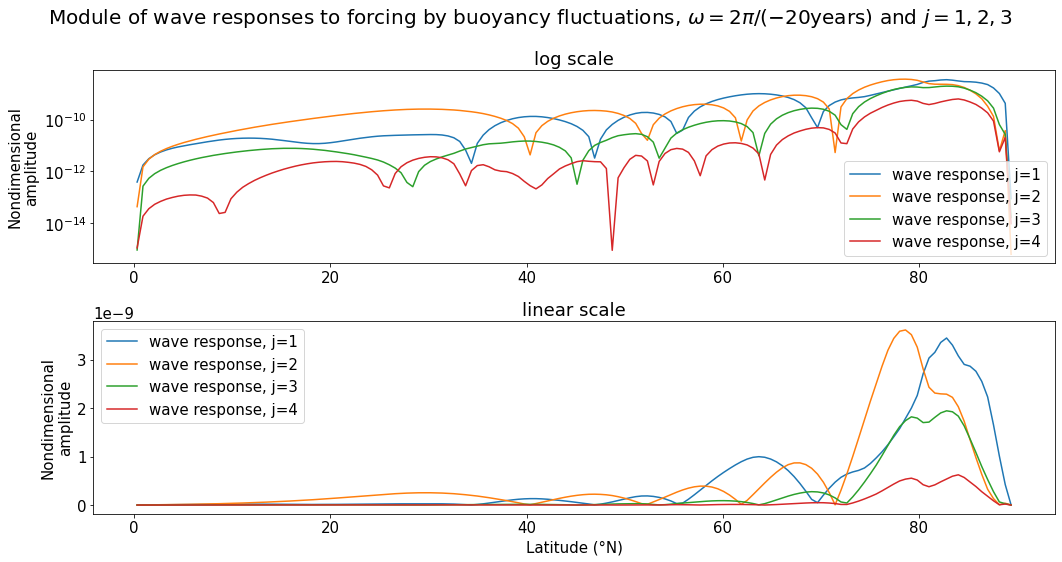

In [11]:
fig,ax=plt.subplots(2,1,figsize=(15,8))
y=set_y(150)
for j in range(1,5):
    freqindex=period_to_freqindex(-20)
    by=set_solve_forced_problem("buoyancy",temperature_y_layer_tilda_150_NH,0.,0.,m,freqindex,j,fixedparams)
    ax[0].plot(np.arcsin(y)*180.0/np.pi,np.abs(np.real(by)),label='wave response, j=%i'%j)
    ax[1].plot(np.arcsin(y)*180.0/np.pi,np.abs(np.real(by)),label='wave response, j=%i'%j)

for i,a in enumerate(ax):
    if  i < 1:
        a.set_yscale('log')
    a.legend()
ax[0].set_title('log scale')
ax[1].set_title('linear scale')
ax[1].set_xlabel('Latitude (°N)')
ax[0].set_ylabel('Nondimensional\namplitude')
ax[1].set_ylabel('Nondimensional\namplitude')

fig.suptitle(r"Module of wave responses to forcing by buoyancy fluctuations, $\omega = 2\pi/(-20\mathrm{ years})$ and $j=1,2,3$ ",fontsize=20)
fig.tight_layout()

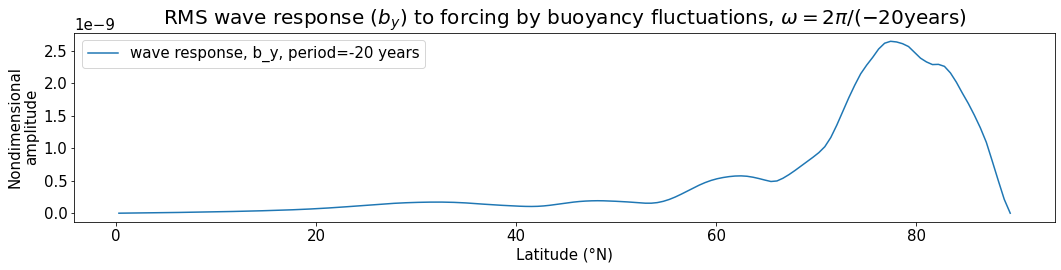

In [12]:
fig,ax=plt.subplots(1,1,figsize=(15,4))
y=set_y(150)
by_all_NH=[]
by_all_SH=[]
for j in range(1,10):
    freqindex=period_to_freqindex(-20)
    by_all_NH.append(set_solve_forced_problem("buoyancy",temperature_y_layer_tilda_150_NH,0.,0.,m,freqindex,j,fixedparams))
    by_all_SH.append(set_solve_forced_problem("buoyancy",temperature_y_layer_tilda_150_SH,0.,0.,m,freqindex,j,fixedparams))

by_rms=0.5*(np.sqrt(0.5*(np.real(np.array(by_all_NH))**2).sum(axis=0))+np.sqrt(0.5*(np.real(np.array(by_all_SH))**2).sum(axis=0)))

ax.plot(np.arcsin(y)*180.0/np.pi,by_rms,label='wave response, b_y, period=-20 years')
    
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel('Nondimensional\namplitude')
ax.set_title(r"RMS wave response ($b_y$) to forcing by buoyancy fluctuations, $\omega = 2\pi/(-20\mathrm{ years})$",fontsize=20)
fig.tight_layout()

In [15]:
L = 3.48e6*0.65
sectoyear = 365.25 * 24 * 60 * 60
Omega = 2*np.pi/86400
velocity_scale = Omega*L

omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega
Nr=9; js=np.arange(1,1+Nr); ks = np.pi/Hprime*js[:,None]
chi = 1 +1j*ks**2/omegaprime*E/Pm
b_to_v_factor = -1j*omegaprime*chi/Brprime/ks


vy_rms=0.5*(np.sqrt(0.5*(np.real(velocity_scale*b_to_v_factor*np.array(by_all_NH))**2).sum(axis=0))+np.sqrt(0.5*(np.real(velocity_scale*b_to_v_factor*np.array(by_all_SH))**2).sum(axis=0)))


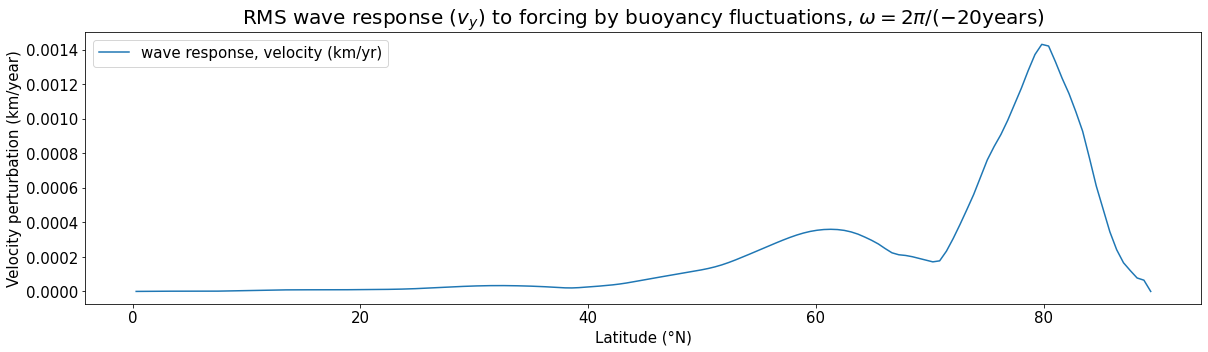

In [16]:
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(np.arcsin(y)*180.0/np.pi,vy_rms/1e3*sectoyear,label='wave response, velocity (km/yr)')
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel('Velocity perturbation (km/year)')
ax.set_title(r"RMS wave response ($v_y$) to forcing by buoyancy fluctuations, $\omega = 2\pi/(-20\mathrm{ years})$",fontsize=20)
fig.tight_layout()

## Power spectrum

Here, we pick the eigenmodes of the unforced problem and express the power distribution of the response to a forcing projected on a specific mode.
e.g., let's say the modes of our problem $Ax - \omega x = 0$ are $(x_n)_{1\leq n \leq N}$. We pick one $n$, identified by its period (related to its eigenvalue $\omega_n$ by $T_n = 2\pi/\omega_n$). We write the forcing (or rather its partial fourier transform) as $F(\omega,y)$, and express it as $F(\omega,y)=\sum_n c_n(\omega) x_n(y)$.

Then, denoting $x(\omega,y)$ the response to the forced problem $Ax(\omega,y) - \omega x(\omega,y) = F(\omega,y)$, one can show $x(\omega,y)=\sum_n \dfrac{c_n(\omega)}{\omega_n-\omega} x_n(y)$. We plot below, for various $n$, the function $\omega \mapsto \left|\dfrac{c_n(\omega)}{\omega_n-\omega}\right|^2$.

One caveat in all this is that $A$ itself depends on $\omega$, through the damping factor $\chi$. We will ignore this dependence by setting $\chi$ as for $\omega = - 2\pi/\text{20 years}$.

01234

Text(0.5, 1.0, '$\\omega^2|c_k(\\omega)/(\\omega_k-\\omega)|^2$')

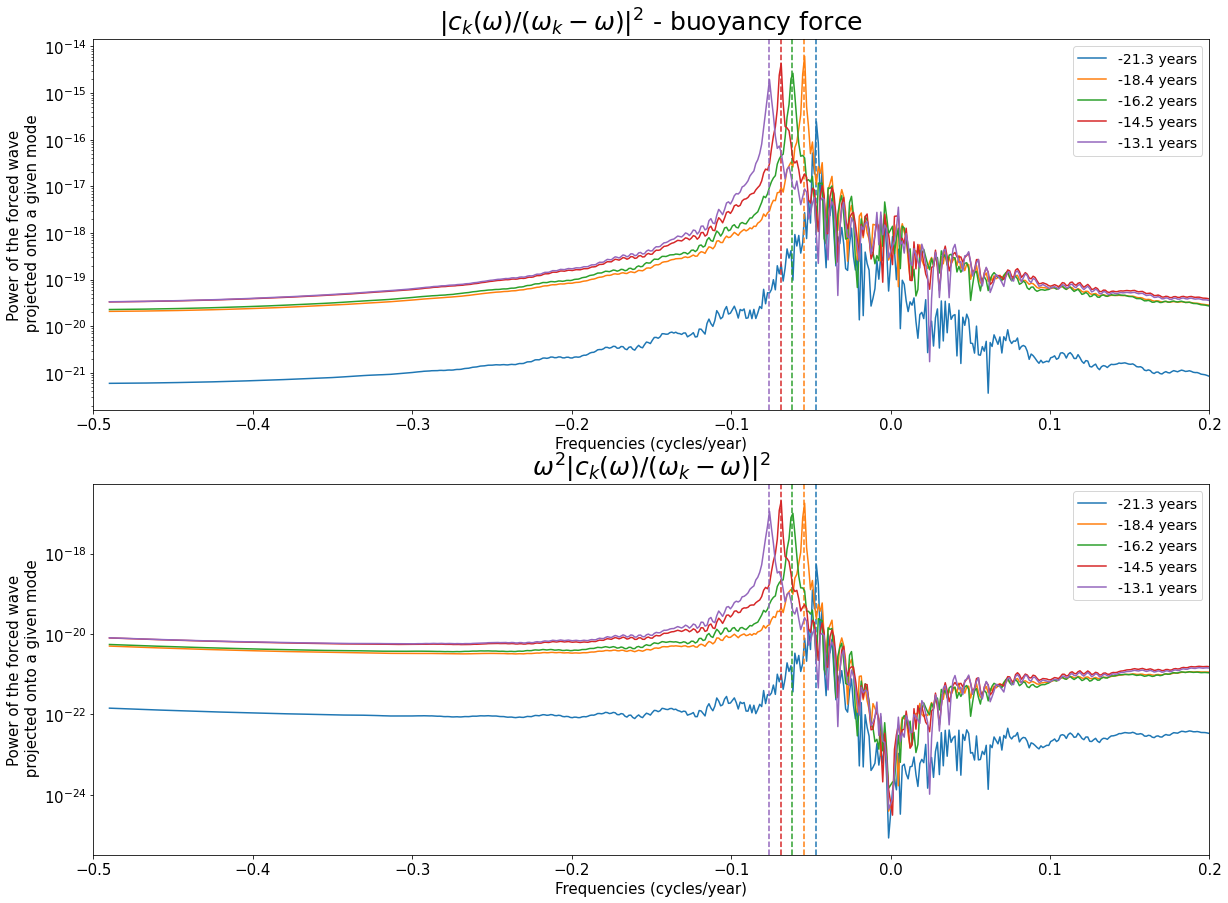

In [41]:
_,(ax,ax2)=plt.subplots(2,1,figsize=(20,15))
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(5):
    print(i,end='')
    frequencies,power_spectrum,period=spectrum_forced_problem("buoyancy",temperature_y_layer_tilda_150_NH,0.,0.,m,i,1,fixedparams,npoints=7)
    ax.plot(frequencies,power_spectrum,color=colors[i%10],label="%.1f years"%period)
    ax2.plot(frequencies,frequencies**2*power_spectrum,color=colors[i%10],label="%.1f years"%period)
    ax.axvline(1/period,color=colors[i%10],linestyle='--')
    ax2.axvline(1/period,color=colors[i%10],linestyle='--')


for a in ax,ax2:
    a.set_xlim(-0.5,0.2) 
    a.legend(fontsize=14)
    a.set_xlabel('Frequencies (cycles/year)')
    a.set_ylabel('Power of the forced wave\n projected onto a given mode')
    a.set_yscale('log')
ax.set_title(r'$|c_k(\omega)/(\omega_k-\omega)|^2$ - buoyancy force',fontsize=25)
ax2.set_title(r'$\omega^2|c_k(\omega)/(\omega_k-\omega)|^2$',fontsize=25)
#ax.axhline(1e-12,color='k')
#ax2.axhline(1e-14,color='k')   

## Amplitude of the acceleration

Here, we compute the root mean square acceleration of the waves forced by buoyancy. For each frequency $\omega$ and $k$, we solve for the forced wave in terms of a magnetic perturbation $\tilde b_y(\omega,k,y)$. We transform it into a velocity perturbation, as above, with $\tilde v_y = \dfrac{i \omega\chi \tilde b_y}{k B_r}$, then into an acceleration as $\tilde a_y = \omega \tilde v_y$. Finally the RMS amplitude is 

$$A_y(y) = \sqrt{\int \dfrac{1}{2}\sum_k |\tilde a_{y}(\omega,k,y)|^2 \mathrm{d} \omega}$$

In discretized terms, the temporal fourier transform has been defined such that $b_y(t_n) = \sum_{m=0}^{N-1} \tilde b_y(\omega_m) e^{-2\pi i \omega_m t_n}$ with $n = 0 \dots N-1$.

There, Parseval's equality reads : $$\frac{1}{N}\sum_{n=0}^{N-1} |b_y(t_n)|^2 = \sum_{m=0}^{N-1} |\tilde b_y(\omega_m)|^2$$

In [42]:
%%time
frequencies=np.sort(nonzero_frequencies())
Omega = 2*np.pi/86400
omegas_nondim=2*np.pi*frequencies[:,None,None]/(Omega*sectoyear)

Nf=len(frequencies)
Nr=2; js=np.arange(1,1+Nr); ks = np.pi/Hprime*js[None,:,None]
by_all_NH_b1=np.zeros((Nf,Nr,150))*1j
by_all_SH_b1=np.zeros((Nf,Nr,150))*1j

for f in range(Nf):
    if f%20==0:
        print(f,end=' ')
    for j in js:
        by_all_NH_b1[f,j-1,:] = set_solve_forced_problem("buoyancy",temperature_y_layer_tilda_150_NH,0.,0.,m,f,j,fixedparams)
        by_all_SH_b1[f,j-1,:] = set_solve_forced_problem("buoyancy",temperature_y_layer_tilda_150_SH,0.,0.,m,f,j,fixedparams)

0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 1min 16s, sys: 5.39 s, total: 1min 22s
Wall time: 29.2 s


In [43]:
# sort by increasing frequency
by_all_NH_sorted=by_all_NH_b1[np.argsort(nonzero_frequencies())]
by_all_SH_sorted=by_all_SH_b1[np.argsort(nonzero_frequencies())]

chi = 1 +1j*ks**2/omegas_nondim*E/Pm
b_to_v_factor = 1j*omegas_nondim*chi/Brprime/ks
v_to_a_factor = omegas_nondim

L = 3.48e6*0.65
velocity_scale = Omega*L
acceleration_scale = Omega**2*L

vy_all_NH = velocity_scale * b_to_v_factor * by_all_NH_sorted
vy_all_SH = velocity_scale * b_to_v_factor * by_all_SH_sorted

sl1=0#350
sl2=800#400
vy_rms_b1=0.5*(np.sqrt( 0.5*(np.abs(vy_all_NH)**2)[sl1:sl2].sum(axis=(0,1)))
           +np.sqrt( 0.5*(np.abs(vy_all_SH)**2)[sl1:sl2].sum(axis=(0,1)))
           )

ay_all_NH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_NH_sorted
ay_all_SH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_SH_sorted

ay_rms_b1=0.5*(np.sqrt( 0.5*(np.abs(ay_all_NH)**2)[sl1:sl2].sum(axis=(0,1)))
           +np.sqrt( 0.5*(np.abs(ay_all_SH)**2)[sl1:sl2].sum(axis=(0,1)))
           )


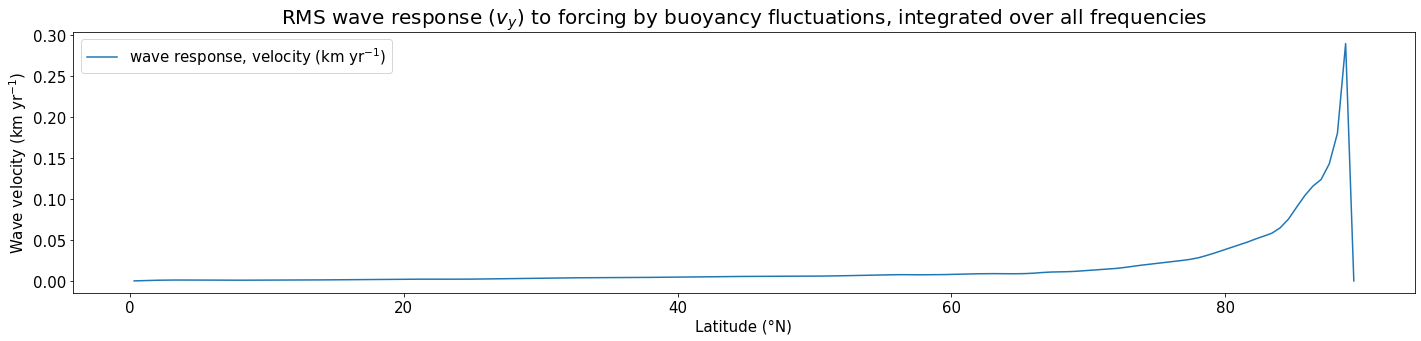

In [44]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
y=set_y(150)
ax.plot(np.arcsin(y)*180.0/np.pi,vy_rms_b1/1e3*sectoyear,label=r'wave response, velocity (km yr$^{-1}$)')
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel(r'Wave velocity (km yr$^{-1}$)')
ax.set_title(r"RMS wave response ($v_y$) to forcing by buoyancy fluctuations, integrated over all frequencies",fontsize=20)
fig.tight_layout()

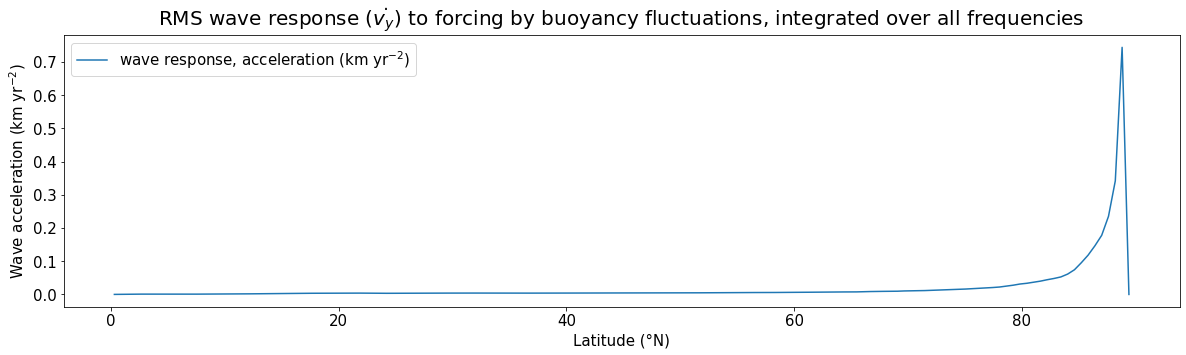

In [45]:
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(np.arcsin(y)*180.0/np.pi,ay_rms_b1/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2}$)')
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel(r'Wave acceleration (km yr$^{-2}$)')
ax.set_title(r"RMS wave response ($\dot{v_y}$) to forcing by buoyancy fluctuations, integrated over all frequencies",fontsize=20)
fig.tight_layout()

In [46]:
# sort by increasing frequency
by_all_NH_sorted=by_all_NH_b1[np.argsort(nonzero_frequencies())]
by_all_SH_sorted=by_all_SH_b1[np.argsort(nonzero_frequencies())]

chi = 1 +1j*ks**2/omegas_nondim*E/Pm
b_to_v_factor = 1j*omegas_nondim*chi/Brprime/ks
v_to_a_factor = omegas_nondim

ay_all_NH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_NH_sorted
ay_all_SH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_SH_sorted

ay_rms_b1=0.5*(np.sqrt( 0.5*(np.abs(ay_all_NH)**2)[:,:,50:].mean(axis=2).sum(axis=1))
           +np.sqrt( 0.5*(np.abs(ay_all_SH)**2)[:,:,50:].mean(axis=2).sum(axis=1))
           )


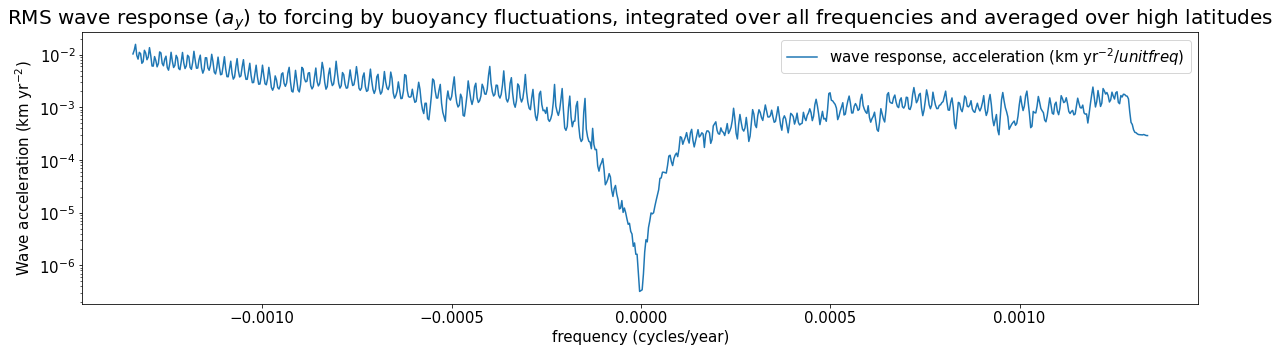

In [47]:
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(omegas_nondim.reshape(-1),ay_rms_b1/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2} /unitfreq$)')
ax.legend()
ax.set_xlabel('frequency (cycles/year)')
ax.set_ylabel(r'Wave acceleration (km yr$^{-2}$)')
ax.set_title(r"RMS wave response ($a_y$) to forcing by buoyancy fluctuations, integrated over all frequencies and averaged over high latitudes",fontsize=20)
fig.tight_layout()
ax.set_yscale('log')

## Amplitude, projected on eigenmodes

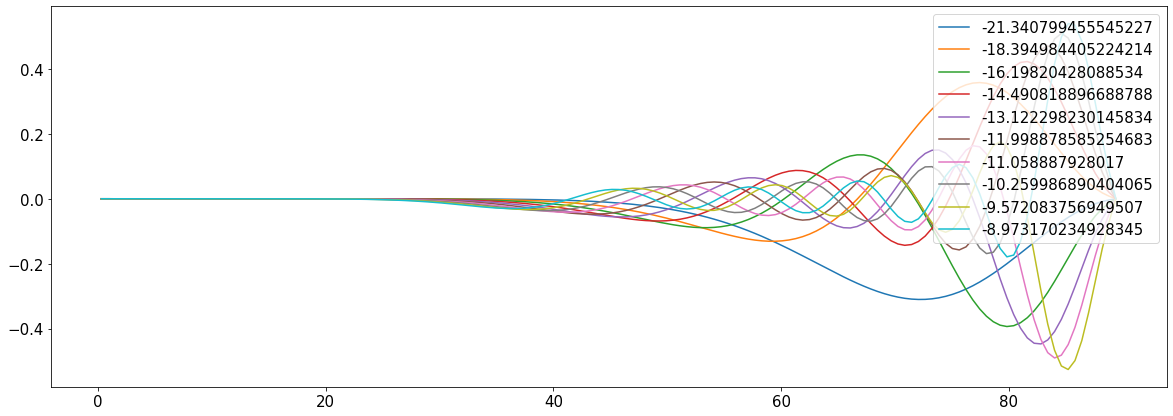

In [189]:
# Plotting the eigenmodes
def plot_eigenmodes(n):
    ngrid=150
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    kprime = np.pi/Hprime
    omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega
    
    C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Compute matrix and eigendecomposition; we make the approximation that eigenmodes don't change much if chi is changed
    A = set_A(ngrid,m,M)
    wi,zi,xi=spl.eig(A,left=True)
    #Normalize left eigenvectors so that zj^H * xi = delta_ij
    zi = zi/np.diagonal(np.dot(zi.transpose().conj(),xi))[None,:].conj()
    #Sort eigenvectors by increasing period
    y=set_y(ngrid)
    xi=xi[:150,np.argsort(np.real(1/wi))]/(1-y[:,None]**2)
    wi=wi[np.argsort(np.real(1/wi))]
    
    _,ax=plt.subplots(1,1,figsize=(20,7))
    for i in range(n):
        C0 = 2/0.65**2*kprime**2/Nprime**2
        eigenmode_period = np.real(2*np.pi*C0/(wi[i]*sectoyear*Omega))
        ax.plot(np.arcsin(y)*180.0/np.pi,np.real(xi[:,i]),label=eigenmode_period)

    ax.legend()
plot_eigenmodes(10)

CPU times: user 12.9 ms, sys: 1.16 ms, total: 14.1 ms
Wall time: 10.1 ms
CPU times: user 317 ms, sys: 9.86 ms, total: 327 ms
Wall time: 381 ms


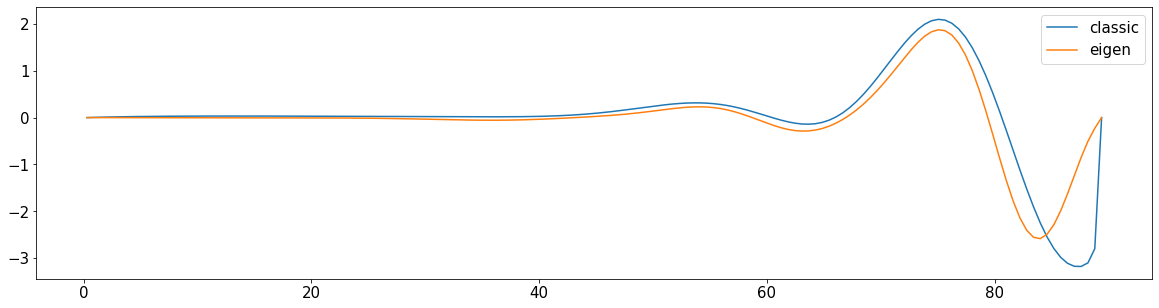

In [228]:
def solve_1(fixedparams):
    ngrid=150
    y = set_y(ngrid)
    
    period = -20
    E,Pm,_,Hprime,Nprime,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    kprime = np.pi*j/Hprime
    omegaprime = 2*np.pi / (period*sectoyear) / Omega
    C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    A = set_A(ngrid,m,M)
    return solve_forced_problem(y,A,C,np.ones(ngrid*2))

def solve_2(fixedparams):
    ngrid=150
    y = set_y(ngrid)
    
    period = -20
    E,Pm,_,Hprime,Nprime,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    kprime = np.pi*j/Hprime
    omegaprime = 2*np.pi / (period*sectoyear) / Omega
    C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    A = set_A(ngrid,m,M)
    
    nmodes=10 #Take the n first modes by order of increasing period
    
    wi,zi,xi=spl.eig(A,left=True)
    #Normalize left eigenvectors so that zj^H * xi = delta_ij
    zi = zi/np.diagonal(np.dot(zi.transpose().conj(),xi))[None,:].conj()
    #Sort eigenvectors by increasing period
    order=np.argpartition(np.real(1/wi),nmodes)
    xi=xi[:,order]
    zi=zi[:,order]
    wi=wi[order]
    rhs=np.ones(ngrid*2)
    return np.sum(np.dot(zi[:,:nmodes].conj().T,rhs)/(wi[:nmodes]-C) * xi[:,:nmodes],axis=1)[:ngrid]/(1-y**2)


_,ax=plt.subplots(1,1,figsize=(20,5))
%time ax.plot(np.arcsin(y)*180.0/np.pi,np.real(solve_1(fixedparams)),label='classic')
%time ax.plot(np.arcsin(y)*180.0/np.pi,np.real(solve_2(fixedparams)),label='eigen')
ax.legend()


In [53]:
%%time
sectoyear = 365.25 * 24 * 60 * 60
frequencies=np.sort(nonzero_frequencies())
Omega = 2*np.pi/86400
omegas_nondim=2*np.pi*frequencies[:,None,None]/(Omega*sectoyear)

Nf=len(frequencies)
Nr=1; js=np.arange(1,1+Nr); ks = np.pi/Hprime*js[None,:,None]
by_all_NH=np.zeros((Nf,Nr,150))*1j
by_all_SH=np.zeros((Nf,Nr,150))*1j

for f in range(Nf):
    if f%20==0:
        print(f,end=' ')
    for j in js:
        by_all_NH[f,j-1,:] = set_solve_forced_problem("buoyancy",temperature_y_layer_tilda_150_NH,0.,0.,m,f,j,fixedparams,limitmodes=10)
        by_all_SH[f,j-1,:] = set_solve_forced_problem("buoyancy",temperature_y_layer_tilda_150_SH,0.,0.,m,f,j,fixedparams,limitmodes=10)

0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 17min 56s, sys: 30.4 s, total: 18min 27s
Wall time: 5min 2s


In [54]:
# sort by increasing frequency
by_all_NH_sorted=by_all_NH[np.argsort(nonzero_frequencies())]
by_all_SH_sorted=by_all_SH[np.argsort(nonzero_frequencies())]

chi = 1 +1j*ks**2/omegas_nondim*E/Pm
b_to_v_factor = 1j*omegas_nondim*chi/Brprime/ks
v_to_a_factor = omegas_nondim

L = 3.48e6*0.65
velocity_scale = Omega*L
acceleration_scale = Omega**2*L

vy_all_NH = velocity_scale * b_to_v_factor * by_all_NH_sorted
vy_all_SH = velocity_scale * b_to_v_factor * by_all_SH_sorted

sl1=0#350
sl2=800#400
vy_rms=0.5*(np.sqrt( 0.5*(np.abs(vy_all_NH)**2)[sl1:sl2].sum(axis=(0,1)))
           +np.sqrt( 0.5*(np.abs(vy_all_SH)**2)[sl1:sl2].sum(axis=(0,1)))
           )

ay_all_NH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_NH_sorted
ay_all_SH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_SH_sorted

ay_rms=0.5*(np.sqrt( 0.5*(np.abs(ay_all_NH)**2)[sl1:sl2].sum(axis=(0,1)))
           +np.sqrt( 0.5*(np.abs(ay_all_SH)**2)[sl1:sl2].sum(axis=(0,1)))
           )


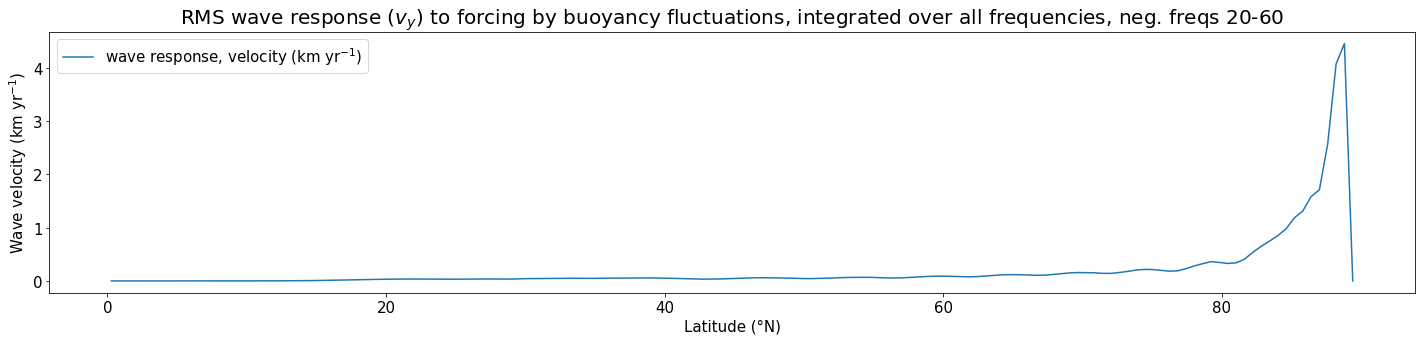

In [66]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
y=set_y(150)
ax.plot(np.arcsin(y)*180.0/np.pi,vy_rms/1e3*sectoyear,label=r'wave response, velocity (km yr$^{-1}$)')
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel(r'Wave velocity (km yr$^{-1}$)')
ax.set_title(r"RMS wave response ($v_y$) to forcing by buoyancy fluctuations, integrated over all frequencies, neg. freqs 20-60",fontsize=20)
fig.tight_layout()

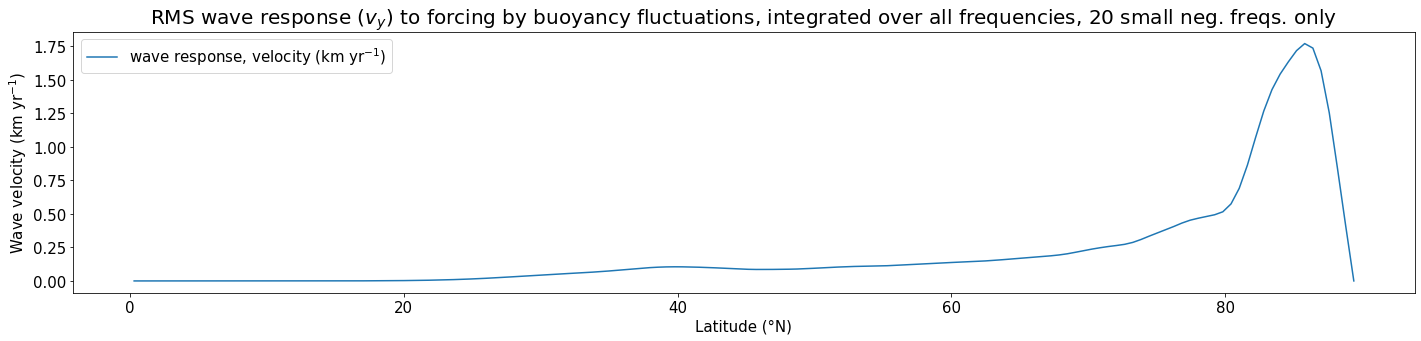

In [61]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
y=set_y(150)
ax.plot(np.arcsin(y)*180.0/np.pi,vy_rms/1e3*sectoyear,label=r'wave response, velocity (km yr$^{-1}$)')
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel(r'Wave velocity (km yr$^{-1}$)')
ax.set_title(r"RMS wave response ($v_y$) to forcing by buoyancy fluctuations, integrated over all frequencies, 20 small neg. freqs. only",fontsize=20)
fig.tight_layout()

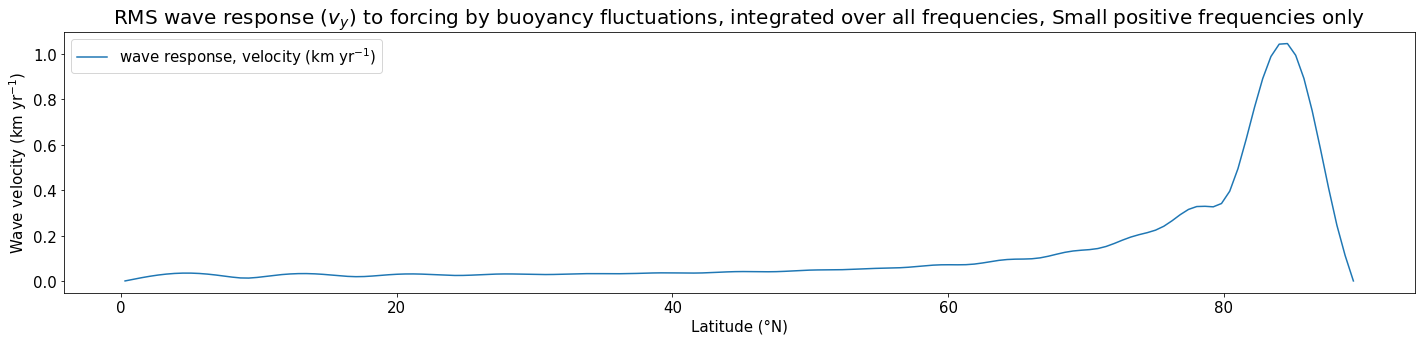

In [56]:
fig,ax=plt.subplots(1,1,figsize=(20,5))
y=set_y(150)
ax.plot(np.arcsin(y)*180.0/np.pi,vy_rms/1e3*sectoyear,label=r'wave response, velocity (km yr$^{-1}$)')
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel(r'Wave velocity (km yr$^{-1}$)')
ax.set_title(r"RMS wave response ($v_y$) to forcing by buoyancy fluctuations, integrated over all frequencies, Small positive frequencies only",fontsize=20)
fig.tight_layout()

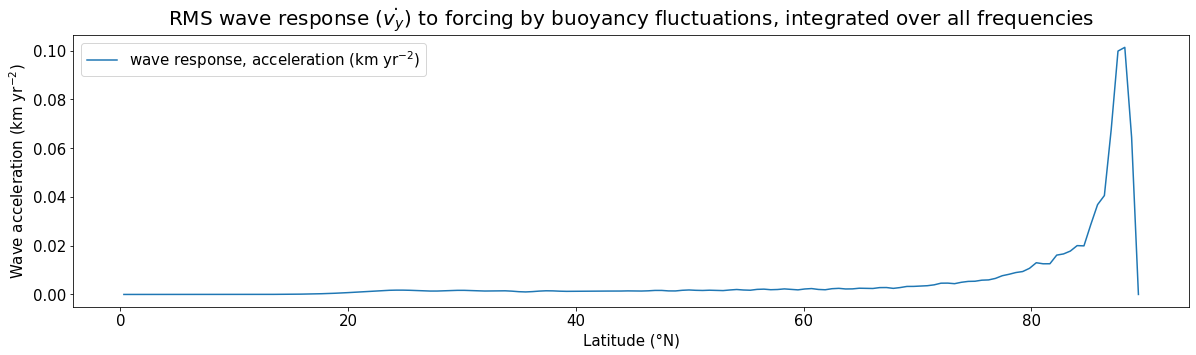

In [55]:
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(np.arcsin(y)*180.0/np.pi,ay_rms/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2}$)')
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel(r'Wave acceleration (km yr$^{-2}$)')
ax.set_title(r"RMS wave response ($\dot{v_y}$) to forcing by buoyancy fluctuations, integrated over all frequencies",fontsize=20)
fig.tight_layout()

In [51]:
# sort by increasing frequency
by_all_NH_sorted=by_all_NH[np.argsort(nonzero_frequencies())]
by_all_SH_sorted=by_all_SH[np.argsort(nonzero_frequencies())]

chi = 1 +1j*ks**2/omegas_nondim*E/Pm
b_to_v_factor = 1j*omegas_nondim*chi/Brprime/ks
v_to_a_factor = omegas_nondim

ay_all_NH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_NH_sorted
ay_all_SH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_SH_sorted

ay_rms=0.5*(np.sqrt( 0.5*(np.abs(ay_all_NH)**2)[:,:,50:].mean(axis=2).sum(axis=1))
           +np.sqrt( 0.5*(np.abs(ay_all_SH)**2)[:,:,50:].mean(axis=2).sum(axis=1))
           )


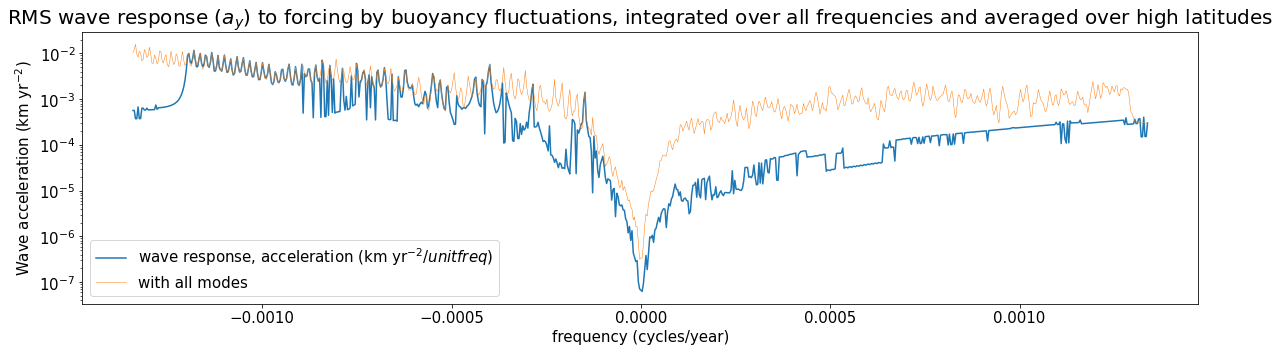

In [52]:
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(omegas_nondim.reshape(-1),ay_rms/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2} /unitfreq$)')
ax.plot(omegas_nondim.reshape(-1),ay_rms_b1/1e3*sectoyear**2,label=r'with all modes',linewidth=0.5)
ax.legend()
ax.set_xlabel('frequency (cycles/year)')
ax.set_ylabel(r'Wave acceleration (km yr$^{-2}$)')
ax.set_title(r"RMS wave response ($a_y$) to forcing by buoyancy fluctuations, integrated over all frequencies and averaged over high latitudes",fontsize=20)
fig.tight_layout()
ax.set_yscale('log')

# Lorentz source

## Response to a fixed frequency

In [125]:
# Fourier transform the forcing. At this time it's still in Calypso scales
lorentz_theta_y_layer_tilda_300=transform_forcing(lorentz_theta_y,'cos')
lorentz_phi_y_layer_tilda_300  =transform_forcing(lorentz_phi_y,'cos')
lorentz_r_y_layer_tilda_300    =transform_forcing(lorentz_r_y,'cos')

In [126]:
# Convert magnitude to diffusion-free scales
E_sim=1e-5
lorentz_theta_y_layer_tilda_300*= E_sim**2
lorentz_phi_y_layer_tilda_300  *= E_sim**2
lorentz_r_y_layer_tilda_300    *= E_sim**2

In [127]:
# Extract NH and SH
lorentz_theta_y_layer_tilda_150_NH = lorentz_theta_y_layer_tilda_300[:,:,150:]
lorentz_phi_y_layer_tilda_150_NH   = lorentz_phi_y_layer_tilda_300[:,:,150:]  
lorentz_r_y_layer_tilda_150_NH     = lorentz_r_y_layer_tilda_300[:,:,150:]    

lorentz_theta_y_layer_tilda_150_SH = lorentz_theta_y_layer_tilda_300[:,:,149::-1]
lorentz_phi_y_layer_tilda_150_SH   = lorentz_phi_y_layer_tilda_300[:,:,149::-1]
lorentz_r_y_layer_tilda_150_SH     = lorentz_r_y_layer_tilda_300[:,:,149::-1]

In [60]:
y=set_y(150)
by_all_NH_r    =[]
by_all_SH_r    =[]
by_all_NH_theta=[]
by_all_SH_theta=[]
by_all_NH_phi  =[]
by_all_SH_phi  =[]

zero=0.*lorentz_r_y_layer_tilda_150_NH

for j in range(1,10):
    freqindex=period_to_freqindex(-20)
    by_all_NH_r.append(set_solve_forced_problem("lorentz",lorentz_r_y_layer_tilda_150_NH,zero,zero,m,freqindex,j,fixedparams))
    by_all_SH_r.append(set_solve_forced_problem("lorentz",lorentz_r_y_layer_tilda_150_SH,zero,zero,m,freqindex,j,fixedparams))
    by_all_NH_theta.append(set_solve_forced_problem("lorentz",zero,lorentz_theta_y_layer_tilda_150_NH,zero,m,freqindex,j,fixedparams))
    by_all_SH_theta.append(set_solve_forced_problem("lorentz",zero,lorentz_theta_y_layer_tilda_150_SH,zero,m,freqindex,j,fixedparams))
    by_all_NH_phi.append(set_solve_forced_problem("lorentz",zero,zero,lorentz_phi_y_layer_tilda_150_NH,m,freqindex,j,fixedparams))
    by_all_SH_phi.append(set_solve_forced_problem("lorentz",zero,zero,lorentz_phi_y_layer_tilda_150_SH,m,freqindex,j,fixedparams))

by_r_rms=0.5*(np.sqrt((np.real(np.array(by_all_NH_r))**2).sum(axis=0))+np.sqrt((np.real(np.array(by_all_SH_r))**2).sum(axis=0)))
by_theta_rms=0.5*(np.sqrt((np.real(np.array(by_all_NH_theta))**2).sum(axis=0))+np.sqrt((np.real(np.array(by_all_SH_theta))**2).sum(axis=0)))
by_phi_rms=0.5*(np.sqrt((np.real(np.array(by_all_NH_phi))**2).sum(axis=0))+np.sqrt((np.real(np.array(by_all_SH_phi))**2).sum(axis=0)))

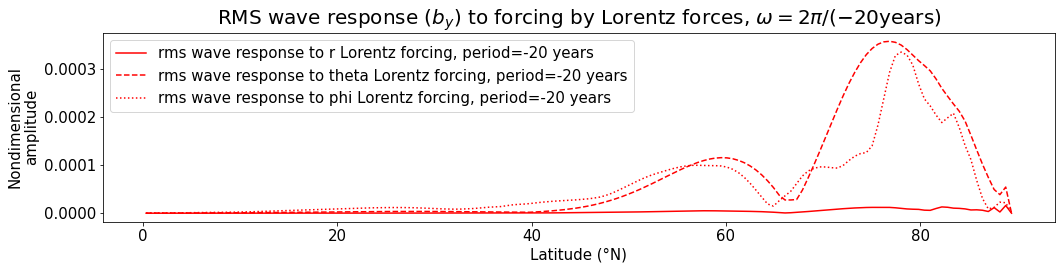

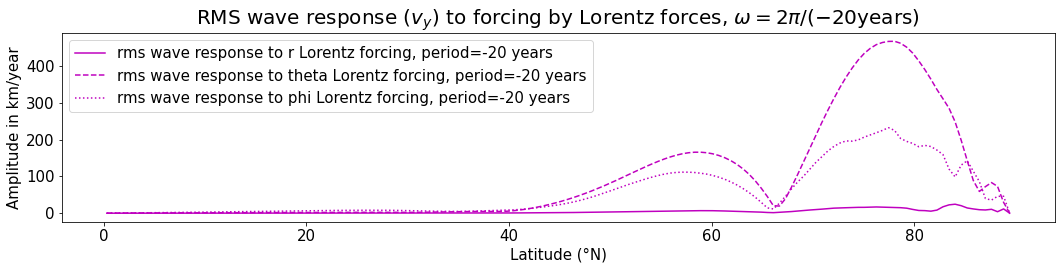

In [70]:
fig,ax=plt.subplots(1,1,figsize=(15,4))
ax.plot(np.arcsin(y)*180.0/np.pi,by_r_rms,label='rms wave response to r Lorentz forcing, period=-20 years'        ,color='r',linestyle='-' )
ax.plot(np.arcsin(y)*180.0/np.pi,by_theta_rms,label='rms wave response to theta Lorentz forcing, period=-20 years',color='r',linestyle='--')
ax.plot(np.arcsin(y)*180.0/np.pi,by_phi_rms,label='rms wave response to phi Lorentz forcing, period=-20 years'    ,color='r',linestyle=':' )

ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel('Nondimensional\namplitude')
ax.set_title(r"RMS wave response ($b_y$) to forcing by Lorentz forces, $\omega = 2\pi/(-20\mathrm{ years})$",fontsize=20)
fig.tight_layout()

vy_r_rms=0.5*(np.sqrt((np.real(velocity_scale*b_to_v_factor*np.array(by_all_NH_r))**2).sum(axis=0))+np.sqrt((np.real(velocity_scale*b_to_v_factor*np.array(by_all_SH_r))**2).sum(axis=0)))
vy_theta_rms=0.5*(np.sqrt((np.real(velocity_scale*b_to_v_factor*np.array(by_all_NH_theta))**2).sum(axis=0))+np.sqrt((np.real(velocity_scale*b_to_v_factor*np.array(by_all_SH_theta))**2).sum(axis=0)))
vy_phi_rms=0.5*(np.sqrt((np.real(velocity_scale*b_to_v_factor*np.array(by_all_NH_phi))**2).sum(axis=0))+np.sqrt((np.real(velocity_scale*b_to_v_factor*np.array(by_all_SH_phi))**2).sum(axis=0)))

fig,ax=plt.subplots(1,1,figsize=(15,4))
ax.plot(np.arcsin(y)*180.0/np.pi,vy_r_rms    /1e3*sectoyear,label='rms wave response to r Lorentz forcing, period=-20 years'    ,color='m',linestyle='-' )
ax.plot(np.arcsin(y)*180.0/np.pi,vy_theta_rms/1e3*sectoyear,label='rms wave response to theta Lorentz forcing, period=-20 years',color='m',linestyle='--')
ax.plot(np.arcsin(y)*180.0/np.pi,vy_phi_rms  /1e3*sectoyear,label='rms wave response to phi Lorentz forcing, period=-20 years'  ,color='m',linestyle=':' )

ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel('Amplitude in km/year')
ax.set_title(r"RMS wave response ($v_y$) to forcing by Lorentz forces, $\omega = 2\pi/(-20\mathrm{ years})$",fontsize=20)
fig.tight_layout()

## Power spectrum on eigenmodes

0123456789

Text(0.5, 1.0, '$\\omega^2|c_k(\\omega)/(\\omega_k-\\omega)|^2$')

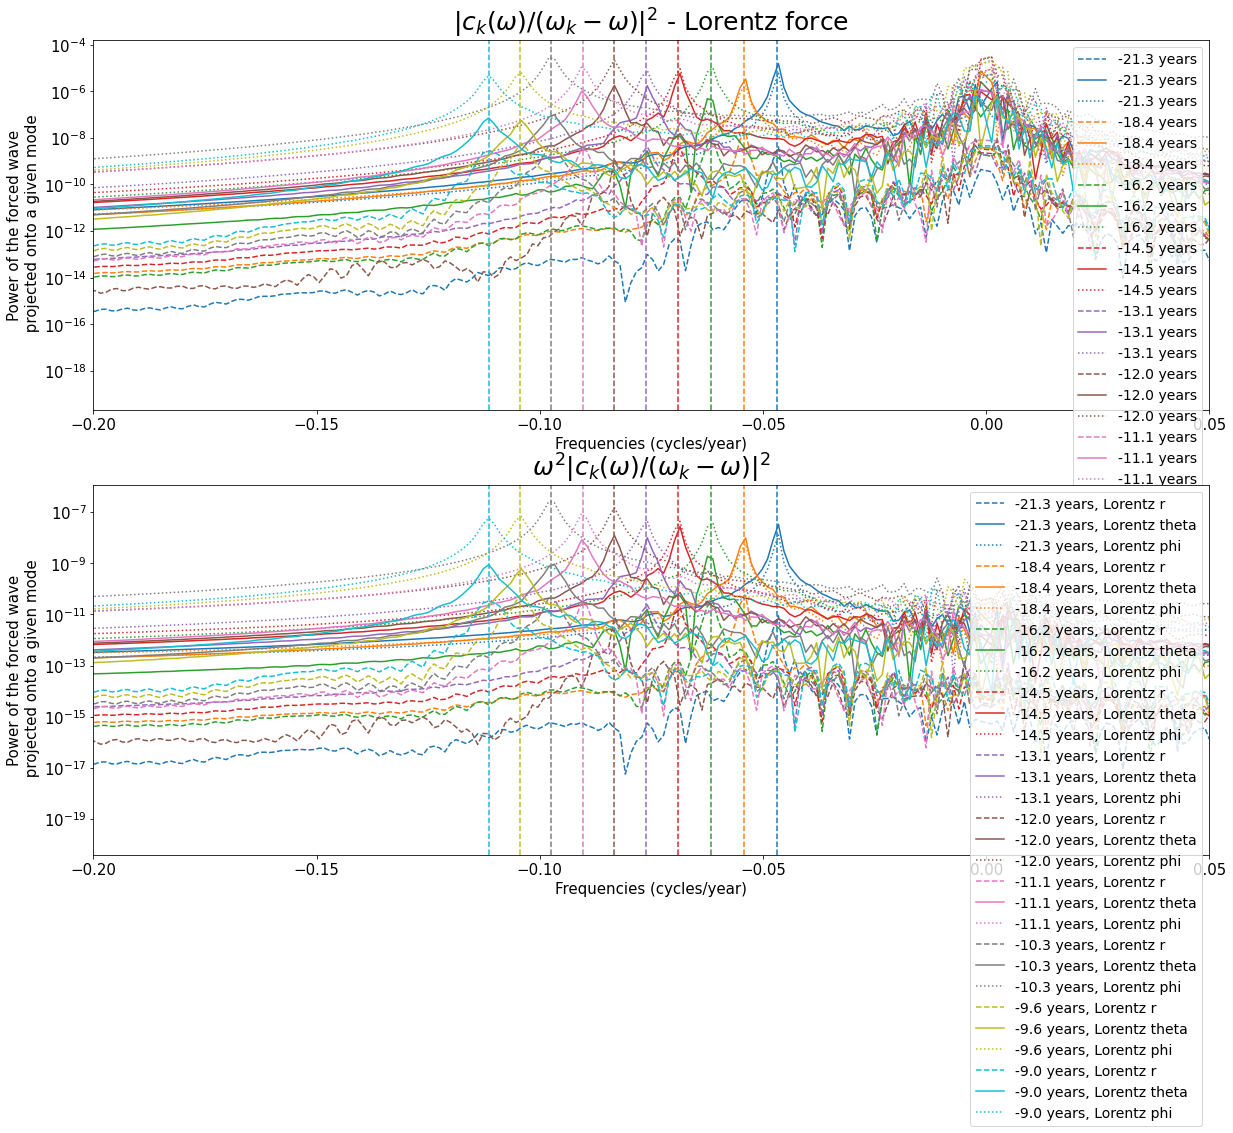

In [82]:
_,(ax,ax2)=plt.subplots(2,1,figsize=(20,15))
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(10):
    print(i,end='')
    frequencies,power_spectrum_r,period=spectrum_forced_problem("lorentz",lorentz_r_y_layer_tilda_150_NH,zero,zero,m,i,1,fixedparams,npoints=7)
    _,power_spectrum_theta,_           =spectrum_forced_problem("lorentz",zero,lorentz_theta_y_layer_tilda_150_NH,zero,m,i,1,fixedparams,npoints=7)
    _,power_spectrum_phi,_             =spectrum_forced_problem("lorentz",zero,zero,lorentz_phi_y_layer_tilda_150_NH,m,i,1,fixedparams,npoints=7)
    
    ax.plot(frequencies,power_spectrum_r    ,color=colors[i%10],label="%.1f years"%period,linestyle='--')
    ax.plot(frequencies,power_spectrum_theta,color=colors[i%10],label="%.1f years"%period,linestyle='-' )
    ax.plot(frequencies,power_spectrum_phi  ,color=colors[i%10],label="%.1f years"%period,linestyle=':' )
    ax2.plot(frequencies,frequencies**2*power_spectrum_r    ,color=colors[i%10],label="%.1f years, Lorentz r"%period,linestyle='--')
    ax2.plot(frequencies,frequencies**2*power_spectrum_theta,color=colors[i%10],label="%.1f years, Lorentz theta"%period,linestyle='-' )
    ax2.plot(frequencies,frequencies**2*power_spectrum_phi  ,color=colors[i%10],label="%.1f years, Lorentz phi"%period,linestyle=':' )
    ax.axvline(1/period,color=colors[i%10],linestyle='--')
    ax2.axvline(1/period,color=colors[i%10],linestyle='--')

for a in ax,ax2:
    a.set_xlim(-0.2,0.05) 
    a.legend(fontsize=14)
    a.set_xlabel('Frequencies (cycles/year)')
    a.set_ylabel('Power of the forced wave\n projected onto a given mode')
    a.set_yscale('log')
ax.set_title(r'$|c_k(\omega)/(\omega_k-\omega)|^2$ - Lorentz force',fontsize=25)
ax2.set_title(r'$\omega^2|c_k(\omega)/(\omega_k-\omega)|^2$',fontsize=25)

    

## Amplitude of the acceleration

In [241]:
%%time
frequencies=np.sort(nonzero_frequencies())
Omega = 2*np.pi/86400
omegas_nondim=2*np.pi*frequencies[:,None,None]/(Omega*sectoyear)

Nf=len(frequencies)
Nr=2; js=np.arange(1,1+Nr); ks = np.pi/Hprime*js[None,:,None]
by_all_NH_l1=np.zeros((Nf,Nr,150))*1j
by_all_SH_l1=np.zeros((Nf,Nr,150))*1j

for f in range(Nf):
    if f%20==0:
        print(f,end=' ')
    for j in js:
        by_all_NH_l1[f,j-1,:] = set_solve_forced_problem("lorentz",lorentz_r_y_layer_tilda_150_NH,lorentz_theta_y_layer_tilda_150_NH,lorentz_phi_y_layer_tilda_150_NH,m,f,j,fixedparams)
        by_all_SH_l1[f,j-1,:] = set_solve_forced_problem("lorentz",lorentz_r_y_layer_tilda_150_SH,lorentz_theta_y_layer_tilda_150_SH,lorentz_phi_y_layer_tilda_150_SH,m,f,j,fixedparams)

0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 50.6 s, sys: 1.3 s, total: 51.9 s
Wall time: 36.4 s


In [145]:
# sort by increasing frequency
by_all_NH_sorted=by_all_NH_l1[np.argsort(nonzero_frequencies())]
by_all_SH_sorted=by_all_SH_l1[np.argsort(nonzero_frequencies())]

chi = 1 +1j*ks**2/omegas_nondim*E/Pm
b_to_v_factor = 1j*omegas_nondim*chi/Brprime/ks
v_to_a_factor = omegas_nondim

L = 3.48e6*0.65
velocity_scale = Omega*L
acceleration_scale = Omega**2*L

vy_all_NH = velocity_scale * b_to_v_factor * by_all_NH_sorted
vy_all_SH = velocity_scale * b_to_v_factor * by_all_SH_sorted

sl1=0
sl2=800
vy_rms_l1=0.5*(np.sqrt( 0.5*(np.abs(vy_all_NH)**2)[sl1:sl2].sum(axis=(0,1)))
           +np.sqrt( 0.5*(np.abs(vy_all_SH)**2)[sl1:sl2].sum(axis=(0,1)))
           )

ay_all_NH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_NH_sorted
ay_all_SH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_SH_sorted

ay_rms_l1=0.5*(np.sqrt( 0.5*(np.abs(ay_all_NH)**2)[sl1:sl2].sum(axis=(0,1)))
           +np.sqrt( 0.5*(np.abs(ay_all_SH)**2)[sl1:sl2].sum(axis=(0,1)))
           )


In [146]:
calypso_to_earth_scale = 1.89e-3

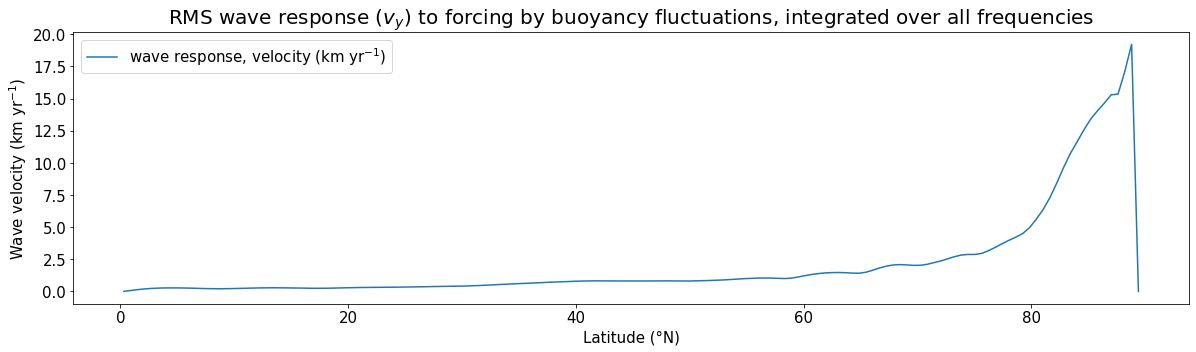

In [147]:
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(np.arcsin(y)*180.0/np.pi,calypso_to_earth_scale *vy_rms_l1/1e3*sectoyear,label=r'wave response, velocity (km yr$^{-1}$)')
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel(r'Wave velocity (km yr$^{-1}$)')
ax.set_title(r"RMS wave response ($v_y$) to forcing by buoyancy fluctuations, integrated over all frequencies",fontsize=20)
fig.tight_layout()

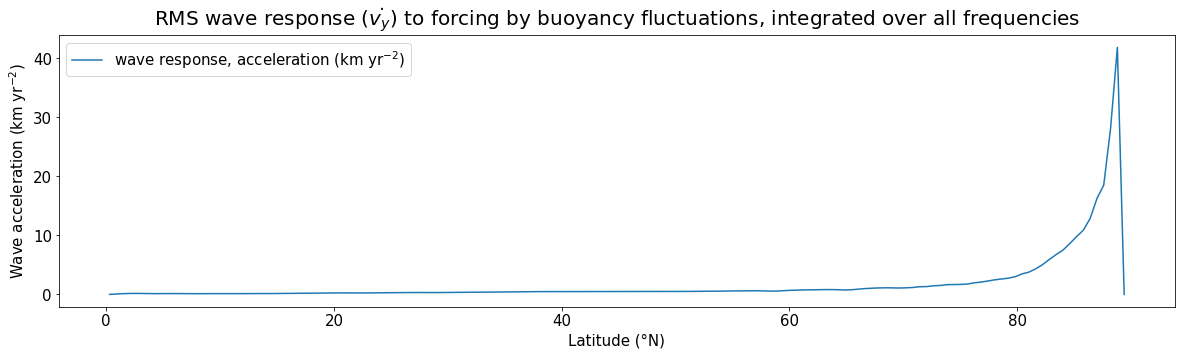

In [148]:
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(np.arcsin(y)*180.0/np.pi,calypso_to_earth_scale*ay_rms_l1/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2}$)')
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel(r'Wave acceleration (km yr$^{-2}$)')
ax.set_title(r"RMS wave response ($\dot{v_y}$) to forcing by buoyancy fluctuations, integrated over all frequencies",fontsize=20)
fig.tight_layout()

In [142]:
# sort by increasing frequency
by_all_NH_sorted=by_all_NH_l1[np.argsort(nonzero_frequencies())]
by_all_SH_sorted=by_all_SH_l1[np.argsort(nonzero_frequencies())]

chi = 1 +1j*ks**2/omegas_nondim*E/Pm
b_to_v_factor = 1j*omegas_nondim*chi/Brprime/ks
v_to_a_factor = omegas_nondim

L = 3.48e6*0.65
velocity_scale = Omega*L
acceleration_scale = Omega**2*L

vy_all_NH = velocity_scale * b_to_v_factor * by_all_NH_sorted
vy_all_SH = velocity_scale * b_to_v_factor * by_all_SH_sorted

vy_rms_l1=0.5*(np.sqrt( 0.5*(np.abs(vy_all_NH)**2).mean(axis=2).sum(axis=1))
           +np.sqrt( 0.5*(np.abs(vy_all_SH)**2).mean(axis=2).sum(axis=1))
           )

ay_all_NH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_NH_sorted
ay_all_SH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_SH_sorted

ay_rms_l1=0.5*(np.sqrt( 0.5*(np.abs(ay_all_NH)**2).mean(axis=2).sum(axis=1))
           +np.sqrt( 0.5*(np.abs(ay_all_SH)**2).mean(axis=2).sum(axis=1))
           )


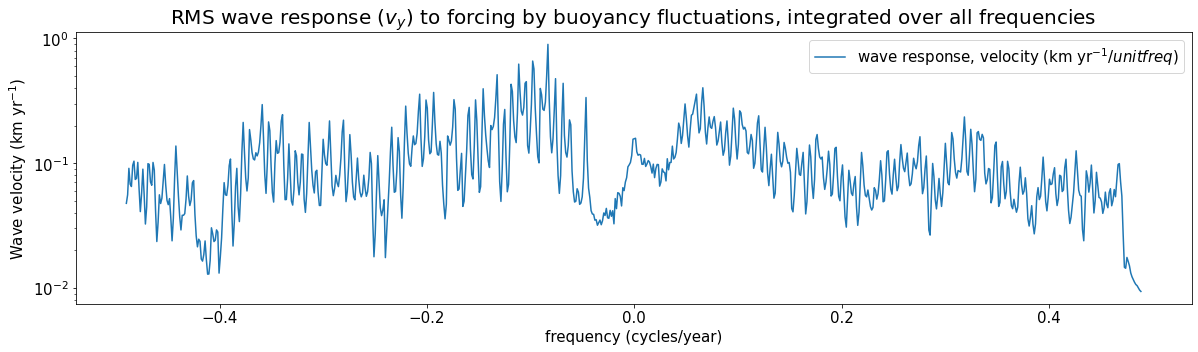

In [143]:
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(sectoyear*Omega*omegas_nondim.reshape(-1)/2/np.pi,calypso_to_earth_scale*vy_rms_l1/1e3*sectoyear,label=r'wave response, velocity (km yr$^{-1} /unitfreq$)')
ax.legend()
ax.set_xlabel('frequency (cycles/year)')
ax.set_ylabel(r'Wave velocity (km yr$^{-1}$)')
ax.set_title(r"RMS wave response ($v_y$) to forcing by buoyancy fluctuations, integrated over all frequencies",fontsize=20)
fig.tight_layout()
ax.set_yscale('log')

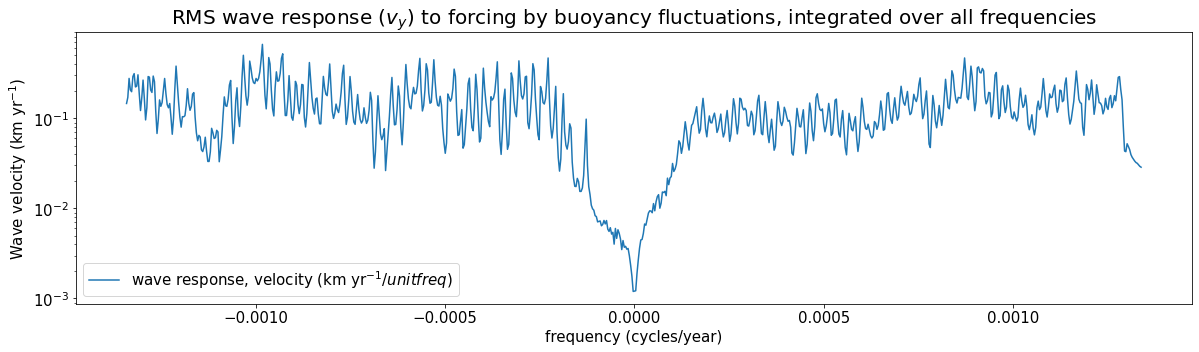

In [144]:
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(omegas_nondim.reshape(-1),calypso_to_earth_scale*ay_rms_l1/1e3*sectoyear**2,label=r'wave response, velocity (km yr$^{-1} /unitfreq$)')
ax.legend()
ax.set_xlabel('frequency (cycles/year)')
ax.set_ylabel(r'Wave velocity (km yr$^{-1}$)')
ax.set_title(r"RMS wave response ($v_y$) to forcing by buoyancy fluctuations, integrated over all frequencies",fontsize=20)
fig.tight_layout()
ax.set_yscale('log')

## Amplitude, projected on eigenmodes

In [247]:
%%time
frequencies=np.sort(nonzero_frequencies())
Omega = 2*np.pi/86400
omegas_nondim=2*np.pi*frequencies[:,None,None]/(Omega*sectoyear)

Nf=len(frequencies)
Nr=2; js=np.arange(1,1+Nr); ks = np.pi/Hprime*js[None,:,None]
by_all_NH_l2=np.zeros((Nf,Nr,150))*1j
by_all_SH_l2=np.zeros((Nf,Nr,150))*1j

for f in range(Nf):
    if f%20==0:
        print(f,end=' ')
    for j in js:
        by_all_NH_l2[f,j-1,:] = set_solve_forced_problem("lorentz",lorentz_r_y_layer_tilda_150_NH,lorentz_theta_y_layer_tilda_150_NH,lorentz_phi_y_layer_tilda_150_NH,m,f,j,fixedparams,limitmodes=10)
        by_all_SH_l2[f,j-1,:] = set_solve_forced_problem("lorentz",lorentz_r_y_layer_tilda_150_SH,lorentz_theta_y_layer_tilda_150_SH,lorentz_phi_y_layer_tilda_150_SH,m,f,j,fixedparams,limitmodes=10)

0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 CPU times: user 12min 33s, sys: 6.02 s, total: 12min 39s
Wall time: 6min 37s


In [248]:
# sort by increasing frequency
by_all_NH_sorted=by_all_NH_l2[np.argsort(nonzero_frequencies())]
by_all_SH_sorted=by_all_SH_l2[np.argsort(nonzero_frequencies())]

chi = 1 +1j*ks**2/omegas_nondim*E/Pm
b_to_v_factor = 1j*omegas_nondim*chi/Brprime/ks
v_to_a_factor = omegas_nondim

L = 3.48e6*0.65
velocity_scale = Omega*L
acceleration_scale = Omega**2*L

vy_all_NH = velocity_scale * b_to_v_factor * by_all_NH_sorted
vy_all_SH = velocity_scale * b_to_v_factor * by_all_SH_sorted

sl1=0
sl2=800
vy_rms_l2=0.5*(np.sqrt( 0.5*(np.abs(vy_all_NH)**2)[sl1:sl2].sum(axis=(0,1)))
           +np.sqrt( 0.5*(np.abs(vy_all_SH)**2)[sl1:sl2].sum(axis=(0,1)))
           )

ay_all_NH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_NH_sorted
ay_all_SH = acceleration_scale * v_to_a_factor * b_to_v_factor * by_all_SH_sorted

ay_rms_l2=0.5*(np.sqrt( 0.5*(np.abs(ay_all_NH)**2)[sl1:sl2].sum(axis=(0,1)))
           +np.sqrt( 0.5*(np.abs(ay_all_SH)**2)[sl1:sl2].sum(axis=(0,1)))
           )


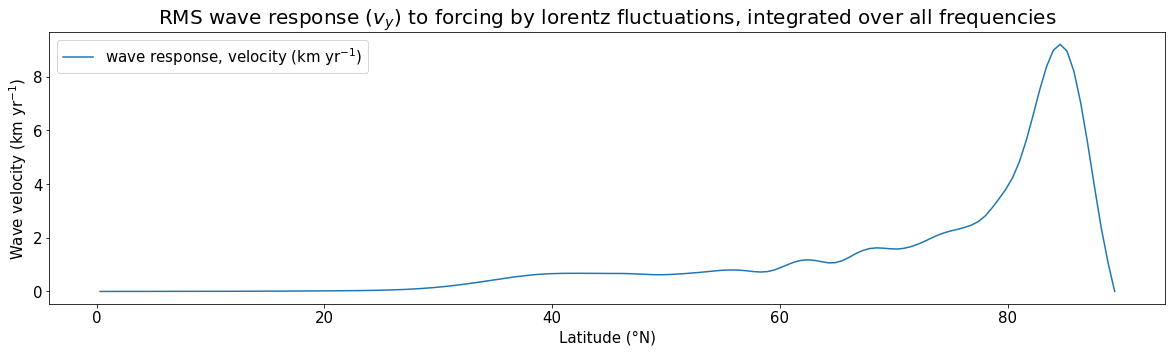

In [251]:
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(np.arcsin(y)*180.0/np.pi,calypso_to_earth_scale *vy_rms_l2/1e3*sectoyear,label=r'wave response, velocity (km yr$^{-1}$)')
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel(r'Wave velocity (km yr$^{-1}$)')
ax.set_title(r"RMS wave response ($v_y$) to forcing by lorentz fluctuations, integrated over all frequencies",fontsize=20)
fig.tight_layout()

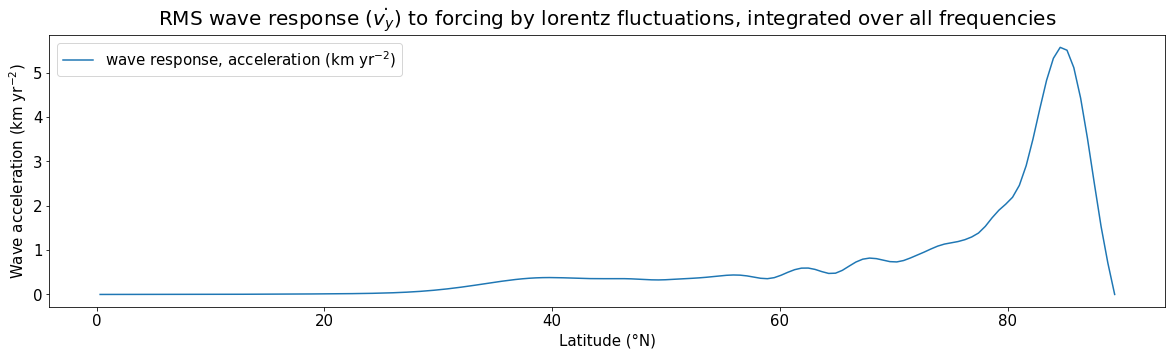

In [252]:
_,ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(np.arcsin(y)*180.0/np.pi,calypso_to_earth_scale*ay_rms_l2/1e3*sectoyear**2,label=r'wave response, acceleration (km yr$^{-2}$)')
ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel(r'Wave acceleration (km yr$^{-2}$)')
ax.set_title(r"RMS wave response ($\dot{v_y}$) to forcing by lorentz fluctuations, integrated over all frequencies",fontsize=20)
fig.tight_layout()

# Induction source

**Remaining : compute rms wave response with all freqs**

## Response to a fixed frequency

758


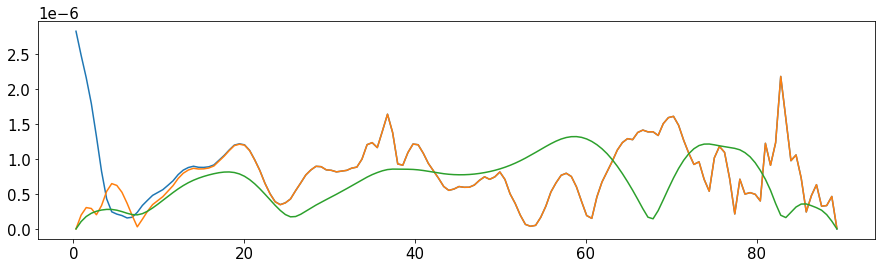

In [178]:
freqindex=period_to_freqindex(-20)
print(freqindex)
fig,ax=plt.subplots(1,1,figsize=(15,4))
test=set_solve_forced_problem("induction",zero,B_theta_y_layer_tilda_150_NH,zero,m,freqindex,1,fixedparams)
test_gev=set_solve_forced_problem_gev("induction",zero,B_theta_y_layer_tilda_150_NH,zero,m,freqindex,1,fixedparams,OPT=1)
test_gev2=set_solve_forced_problem_gev("induction",zero,B_theta_y_layer_tilda_150_NH,zero,m,freqindex,1,fixedparams,OPT=2)

ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(test))
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(test_gev))
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(test_gev2))

751


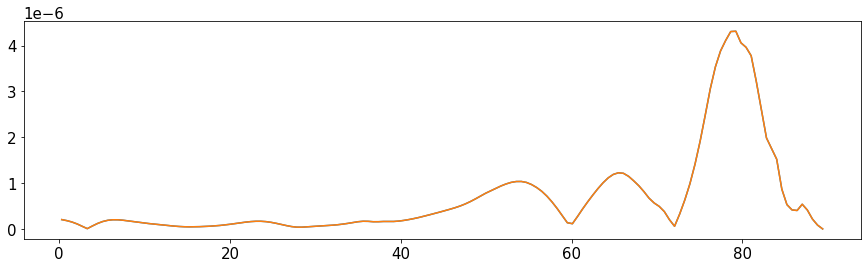

In [162]:
freqindex=period_to_freqindex(-17)
print(freqindex)
fig,ax=plt.subplots(1,1,figsize=(15,4))
test=set_solve_forced_problem("induction",zero,zero,B_phi_y_layer_tilda_150_NH,m,freqindex,1,fixedparams)
test_gev=set_solve_forced_problem("induction",zero,zero,B_phi_y_layer_tilda_150_NH,m,freqindex,1,fixedparams)
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(test))
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(test_gev))

758


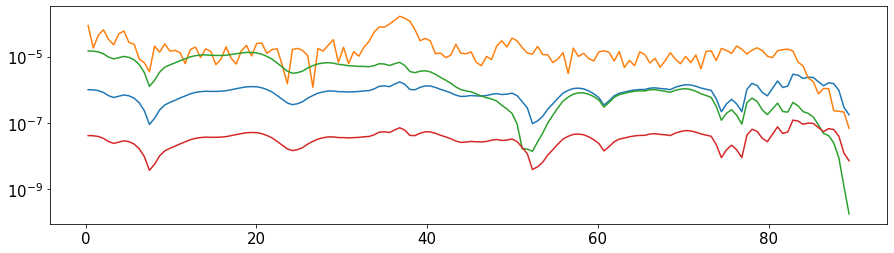

In [175]:
freqindex=period_to_freqindex(-20)
print(freqindex)
fig,ax=plt.subplots(1,1,figsize=(15,4))
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(B_theta_y_layer_tilda_150_NH[freqindex,0,:]))
rhs1,rhs2,rhs3=rhs_test("induction",zero,B_theta_y_layer_tilda_150_NH,zero,m,freqindex,1,fixedparams)
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(rhs1))
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(rhs2))
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(rhs3))
ax.set_yscale('log')

In [170]:
def rhs_test(forcing_name,forcingtilda_r,forcingtilda_theta,forcingtilda_phi,m,freqindex,j,fixedparams,npoints=7,limitmodes=False):
    # Compute C and M
    ngrid = forcingtilda_r.shape[2]  
    period = freqindex_to_period(freqindex)
    
    E,Pm,_,Hprime,Nprime,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    kprime = np.pi*j/Hprime
    omegaprime = 2*np.pi / (period*sectoyear) / Omega
    
    C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Set up unforced problem
    y = set_y(ngrid)
    A = set_A(ngrid,m,M,npoints)
    
    # Compute forcings & setup RHS
    if forcing_name == "induction":
        FItheta_pp = forcingtilda_theta[freqindex,j-1,:]*(1-y**2)
        FIphi_p = forcingtilda_phi[freqindex,j-1,:]/np.sqrt(1-y**2)

        D1 = make_D_fornberg(y,1,npoints=npoints)
        D2 = make_D_fornberg(y,2,npoints=npoints)
        
        forcingtheta1 = 1/chi*(np.dot(D2,FItheta_pp))
        forcingtheta2 = 1/chi*((C**2*y**2+m*C)/(M*(1-y**2))*FItheta_pp)
        forcingtheta3 = 1/chi*((1-y**2)**(-2)*FItheta_pp)
        
        rhs1 = -(forcingtheta1)*M*(1-y**2)
        rhs2 = -(forcingtheta2)*M*(1-y**2)
        rhs3 = -(forcingtheta3)*M*(1-y**2)
    return rhs1,rhs2,rhs3


758


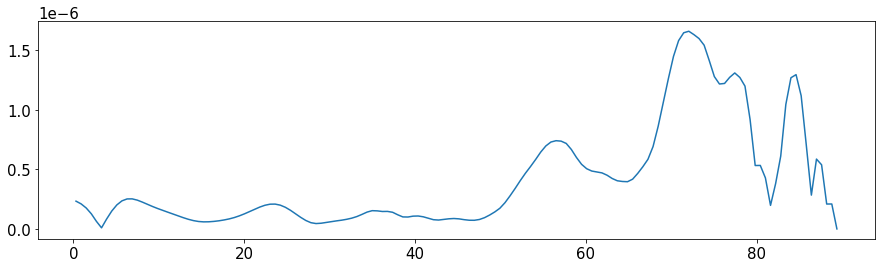

In [92]:
freqindex=period_to_freqindex(-20)
print(freqindex)
fig,ax=plt.subplots(1,1,figsize=(15,4))
test=set_solve_forced_problem("induction",zero,zero,B_phi_y_layer_tilda_150_NH,m,freqindex,1,fixedparams)
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(test))

In [53]:
# Fourier transform the forcing. At this time it's still in Calypso scales
B_theta_y_layer_tilda_300=transform_forcing(B_theta_y,'sin')
B_phi_y_layer_tilda_300  =transform_forcing(B_phi_y,'sin')

In [56]:
# Convert magnitude to diffusion-free scales
E_sim=1e-5
Pm_sim=0.5
B_theta_y_layer_tilda_300*= np.sqrt(E_sim/Pm_sim)
B_phi_y_layer_tilda_300  *= np.sqrt(E_sim/Pm_sim)

In [57]:
# Extract NH and SH
B_theta_y_layer_tilda_150_NH = B_theta_y_layer_tilda_300[:,:,150:]
B_phi_y_layer_tilda_150_NH   = B_phi_y_layer_tilda_300[:,:,150:]  

B_theta_y_layer_tilda_150_SH = B_theta_y_layer_tilda_300[:,:,149::-1]
B_phi_y_layer_tilda_150_SH   = B_phi_y_layer_tilda_300[:,:,149::-1]

In [60]:
y=set_y(150)
by_all_NH_theta=[]
by_all_SH_theta=[]
by_all_NH_phi  =[]
by_all_SH_phi  =[]

zero=0.*B_theta_y_layer_tilda_150_NH

for j in range(1,10):
    freqindex=period_to_freqindex(-20)
    by_all_NH_theta.append(set_solve_forced_problem("induction",zero,B_theta_y_layer_tilda_150_NH,zero,m,freqindex,j,fixedparams))
    by_all_SH_theta.append(set_solve_forced_problem("induction",zero,B_theta_y_layer_tilda_150_NH,zero,m,freqindex,j,fixedparams))
    by_all_NH_phi.append(  set_solve_forced_problem("induction",zero,zero,B_phi_y_layer_tilda_150_NH,m,freqindex,j,fixedparams))
    by_all_SH_phi.append(  set_solve_forced_problem("induction",zero,zero,B_phi_y_layer_tilda_150_NH,m,freqindex,j,fixedparams))
by_theta_rms=0.5*(np.sqrt((np.real(np.array(by_all_NH_theta))**2).sum(axis=0))+np.sqrt((np.real(np.array(by_all_SH_theta))**2).sum(axis=0)))
by_phi_rms=0.5*(np.sqrt((np.real(np.array(by_all_NH_phi))**2).sum(axis=0))+np.sqrt((np.real(np.array(by_all_SH_phi))**2).sum(axis=0)))

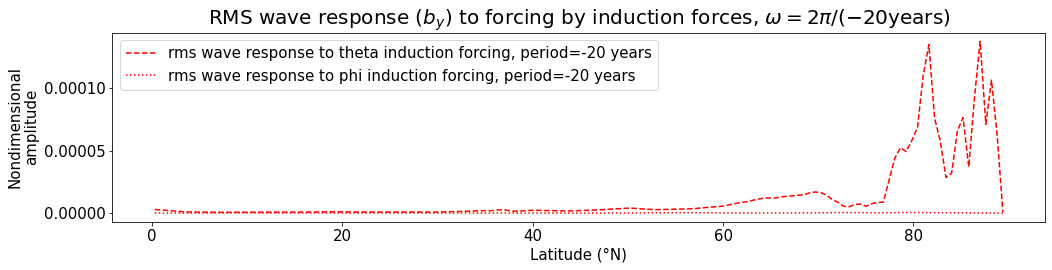

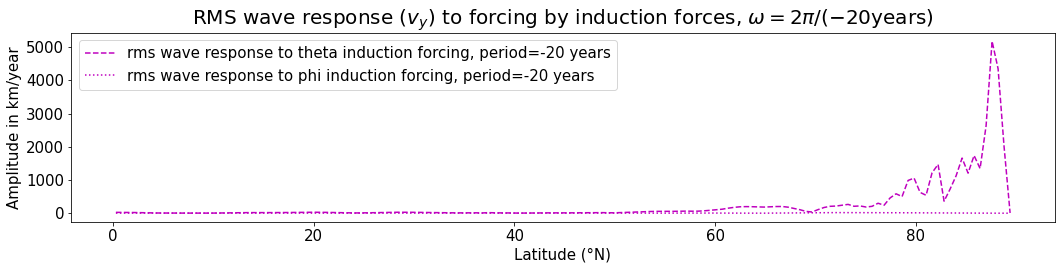

In [66]:
fig,ax=plt.subplots(1,1,figsize=(15,4))
ax.plot(np.arcsin(y)*180.0/np.pi,by_theta_rms,label='rms wave response to theta induction forcing, period=-20 years',color='r',linestyle='--')
ax.plot(np.arcsin(y)*180.0/np.pi,by_phi_rms,label='rms wave response to phi induction forcing, period=-20 years'    ,color='r',linestyle=':' )

ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel('Nondimensional\namplitude')
ax.set_title(r"RMS wave response ($b_y$) to forcing by induction forces, $\omega = 2\pi/(-20\mathrm{ years})$",fontsize=20)
fig.tight_layout()


Omega = 2*np.pi/86400
omega_nondim=2*np.pi*(-1/20)/(Omega*sectoyear)
ks = np.arange(1,10)[:,None]
chi = 1 +1j*ks**2/omega_nondim*E/Pm
b_to_v_factor = 1j*omega_nondim*chi/Brprime/ks
L = 3.48e6*0.65
velocity_scale = Omega*L

vy_theta_rms=0.5*(np.sqrt((np.real(velocity_scale*b_to_v_factor*np.array(by_all_NH_theta))**2).sum(axis=0))+np.sqrt((np.real(velocity_scale*b_to_v_factor*np.array(by_all_SH_theta))**2).sum(axis=0)))
vy_phi_rms=0.5*(np.sqrt((np.real(velocity_scale*b_to_v_factor*np.array(by_all_NH_phi))**2).sum(axis=0))+np.sqrt((np.real(velocity_scale*b_to_v_factor*np.array(by_all_SH_phi))**2).sum(axis=0)))

fig,ax=plt.subplots(1,1,figsize=(15,4))
ax.plot(np.arcsin(y)*180.0/np.pi,vy_theta_rms/1e3*sectoyear,label='rms wave response to theta induction forcing, period=-20 years',color='m',linestyle='--')
ax.plot(np.arcsin(y)*180.0/np.pi,vy_phi_rms  /1e3*sectoyear,label='rms wave response to phi induction forcing, period=-20 years'  ,color='m',linestyle=':' )

ax.legend()
ax.set_xlabel('Latitude (°N)')
ax.set_ylabel('Amplitude in km/year')
ax.set_title(r"RMS wave response ($v_y$) to forcing by induction forces, $\omega = 2\pi/(-20\mathrm{ years})$",fontsize=20)
fig.tight_layout()

# Paper figures

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


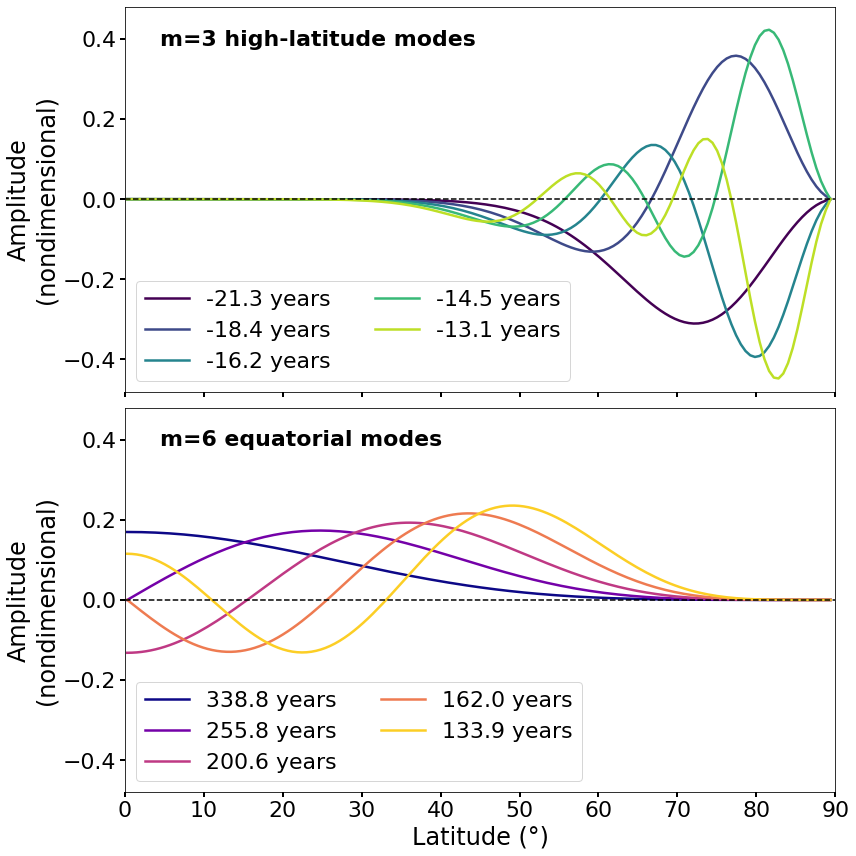

In [208]:
# Plotting the first few high-lat and equatorial eigenmodes
def plot_eigenmodes(ax,n1,n2,westward_traveling=True,m=3,colors=1,loc=2):
    ngrid=150

    kprime = np.pi/Hprime
    omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega
    
    C0 = 2/0.65**2*kprime**2/Nprime**2
    C = C0*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Compute matrix and eigendecomposition, with dirichlet BC
    y=set_y(ngrid)
    A = set_A(ngrid,m,M,option=1)
    wi,xi=spl.eig(A)
    if not westward_traveling: # Add Neumann BC solutions as well
        A = set_A(ngrid,m,M,option=2)
        wi_n,xi_n=spl.eig(A)
        wi=np.concatenate([wi,wi_n])
        xi=np.concatenate([xi,xi_n],axis=1)
    #Merge all eigenvalues and eigenvectors; and sort them by increasing period
    if westward_traveling:
        order=np.argsort(np.real(1/wi))
    else:
        order=np.argsort(-np.real(1/wi))
        xi*=np.sign(xi[len(y)-10])
    xi=xi[:len(y),order]/(1-y[:,None]**2)
    wi=wi[order]
    
    lns='-'
    lw=2.5
    if colors==1:
        clrs=plt.cm.viridis(np.linspace(0,0.9,n2-n1))
    elif colors==2:
        clrs=plt.cm.plasma(np.linspace(0,0.9,n2-n1))
    
    for i in range(n1,n2):
        eigenmode_period = np.real(2*np.pi*C0/(wi[i]*sectoyear*Omega))
        ax.plot(np.arcsin(y)*180.0/np.pi,np.real(xi[:,i]),label="%.1f years"%eigenmode_period,linestyle=lns,linewidth=lw,color=clrs[i-n1])

    ax.set_xlim(0,90)
    ax.legend(loc=loc,ncol=2)#,fontsize=20,borderpad=0.3,labelspacing=0.4,borderaxespad=0.3)
    ax.set_ylim(-0.48,0.48)
    ax.set_ylabel("Amplitude\n(nondimensional)",fontsize=24)
    ax.axhline(0.,linestyle='--',color='k')
    ax.tick_params(width=2,length=5)
    


matplotlib.rcParams.update({'font.size':22})
fig,(ax,ax2)=plt.subplots(2,1,figsize=(12,12))
plot_eigenmodes(ax ,0,5,westward_traveling=True ,m=3,colors=1,loc=3)
plot_eigenmodes(ax2,0,5,westward_traveling=False,m=6,colors=2,loc=3)
ax2.set_xlabel("Latitude (°)",fontsize=24)
ax.set_xticks(range(0,100,10))
ax.set_xticklabels([""]*10)
xt=0.05;yt=0.9
ax.text( xt,yt, 'm=3 high-latitude modes',fontweight='bold', transform=ax.transAxes)
ax2.text(xt,yt, 'm=6 equatorial modes'   ,fontweight='bold', transform=ax2.transAxes)
fig.tight_layout(pad=0.5)
fig.savefig('/Users/quentin.nicolas/Downloads/modes.eps', format='eps',bbox_inches='tight')

westward-traveling power : 9.51e-11
eastward-traveling power : 9.20e-11


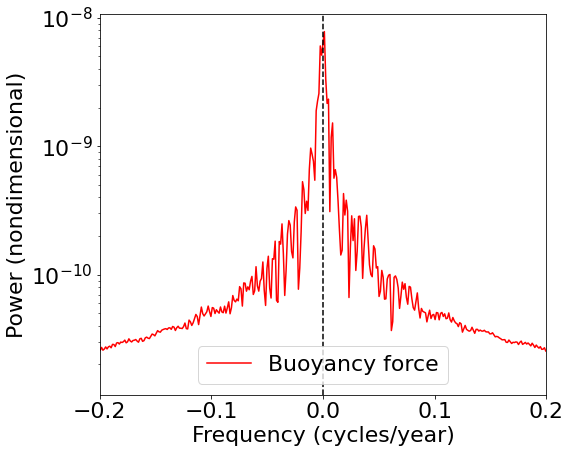

In [72]:
# Power spectra and rms sources

def plot_spectrum_source(ax,forcing_name,forcingtilda_r,forcingtilda_theta,forcingtilda_phi,fixedparams,lbl,clr,lns='-',print_pwr=False):    
    # adapts chi
    nt,_,ngrid=forcingtilda_r.shape
    y=set_y(ngrid//2,two_sides=True)
    #y=set_y(ngrid)
    
    freqs = nonzero_frequencies() # all frequencies in years^-1
    Fr = 1j*np.zeros((nt,ngrid))
    Ftheta,Fphi=np.copy(Fr),np.copy(Fr)
    # Compute forcings
    if forcing_name == "buoyancy":
        for freqindex in range(nt):
            Fr[freqindex],Ftheta[freqindex],Fphi[freqindex] = set_buoyancy_forcing(forcingtilda_r,freqindex,1,fixedparams)
    elif forcing_name == "lorentz":
        for freqindex in range(nt):
            Fr[freqindex],Ftheta[freqindex],Fphi[freqindex] = set_lorentz_forcing(forcingtilda_r,forcingtilda_theta,forcingtilda_phi,freqindex,1,fixedparams)
    Fr_yavg = np.trapz(Fr*y/np.sqrt(1-y**2),y,axis=1)
    Ftheta_yavg = np.trapz(Ftheta*y/np.sqrt(1-y**2),y,axis=1)
    Fphi_yavg = np.trapz(Fphi*y/np.sqrt(1-y**2),y,axis=1)
    permut = np.roll(np.arange(nt),(nt+1)//2)
    ax.plot(freqs[permut],np.abs(Fr_yavg+Ftheta_yavg+Fphi_yavg)[permut],label=lbl,color=clr,linestyle=lns)
    #ax.plot(-freqs[permut],np.abs(Fr_yavg)[permut])
    if print_pwr:
        print("westward-traveling power : %.2e"%(np.abs(Fr_yavg+Ftheta_yavg+Fphi_yavg)[permut][:nt//2+1].mean()))
        print("eastward-traveling power : %.2e"%(np.abs(Fr_yavg+Ftheta_yavg+Fphi_yavg)[permut][nt//2+1:].mean()))
    ax.set_yscale('log')
    ax.set_xlabel('Frequency (cycles/year)')
    ax.set_xlim(-0.2,0.2)
    ax.set_ylabel('Power (nondimensional)')
    ax.axvline(0.,color='k',linestyle='--')
    ax.legend()

matplotlib.rcParams.update({'font.size':22})
fig,ax=plt.subplots(1,1,figsize=(8,7))
plot_spectrum_source(ax,"buoyancy",temperature_y_layer_tilda_300,0.,0.,fixedparams,"Buoyancy force",'red',print_pwr=True)


westward-traveling power : 1.34e-08
eastward-traveling power : 1.52e-08
westward-traveling power : 1.46e-06
eastward-traveling power : 1.49e-06
westward-traveling power : 8.71e-07
eastward-traveling power : 9.78e-07


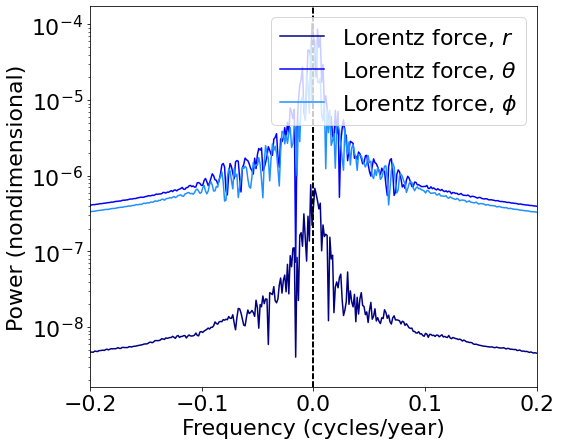

In [73]:
matplotlib.rcParams.update({'font.size':22})
fig,ax=plt.subplots(1,1,figsize=(8,7))
plot_spectrum_source(ax,"lorentz",lorentz_r_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300   ,fixedparams,r"Lorentz force, $r$"     ,'navy'      ,print_pwr=True)
plot_spectrum_source(ax,"lorentz",0*lorentz_r_y_layer_tilda_300,lorentz_theta_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300,fixedparams,r"Lorentz force, $\theta$",'blue'      ,print_pwr=True)
plot_spectrum_source(ax,"lorentz",0*lorentz_r_y_layer_tilda_300,lorentz_phi_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300  ,fixedparams,r"Lorentz force, $\phi$"  ,'dodgerblue',print_pwr=True)


In [84]:
# Power spectra and rms sources

def plot_rms_source(ax,forcing_name,forcingtilda_r,forcingtilda_theta,forcingtilda_phi,fixedparams,lbl,clr,lns='-'):    
    # adapts chi
    nt,_,ngrid=forcingtilda_r.shape
    ngrid=ngrid//2
    y=set_y(ngrid)

    Fr = 1j*np.zeros((nt,2*ngrid))
    Ftheta,Fphi=np.copy(Fr),np.copy(Fr)
    # Compute forcings
    if forcing_name == "buoyancy":
        for freqindex in range(nt):
            Fr[freqindex],Ftheta[freqindex],Fphi[freqindex] = set_buoyancy_forcing(forcingtilda_r,freqindex,1,fixedparams)
    elif forcing_name == "lorentz":
        for freqindex in range(nt):
            Fr[freqindex],Ftheta[freqindex],Fphi[freqindex] = set_lorentz_forcing(forcingtilda_r,forcingtilda_theta,forcingtilda_phi,freqindex,1,fixedparams)
    Fr_rms=0.5*(np.sqrt( 0.5*(np.abs(Fr[:,ngrid:])**2).sum(axis=0))
               +np.sqrt( 0.5*(np.abs(Fr[:,:ngrid][::-1])**2).sum(axis=0))
               )
    Ftheta_rms=0.5*(np.sqrt( 0.5*(np.abs(Ftheta[:,ngrid:])**2).sum(axis=0))
                   +np.sqrt( 0.5*(np.abs(Ftheta[:,:ngrid][::-1])**2).sum(axis=0))
           )
    Fphi_rms=0.5*(np.sqrt( 0.5*(np.abs(Fphi[:,ngrid:])**2).sum(axis=0))
                 +np.sqrt( 0.5*(np.abs(Fphi[:,:ngrid][::-1])**2).sum(axis=0))
           )    

    ax.plot(np.arcsin(y)*180.0/np.pi,Fr_rms+Ftheta_rms+Fphi_rms,label=lbl,color=clr,linestyle=lns,linewidth=2)
    #ax.set_yscale('log')
    ax.set_xlabel('Latitude (°)')
    ax.set_xlim(0.,90)
    ax.set_ylabel('RMS amplitude (nondimensional)')
    #ax.set_ylim(0.,1.1*np.max(Fr_rms+Ftheta_rms+Fphi_rms))
    #ax.axvline(0.,color='k',linestyle='--')
    ax.legend()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


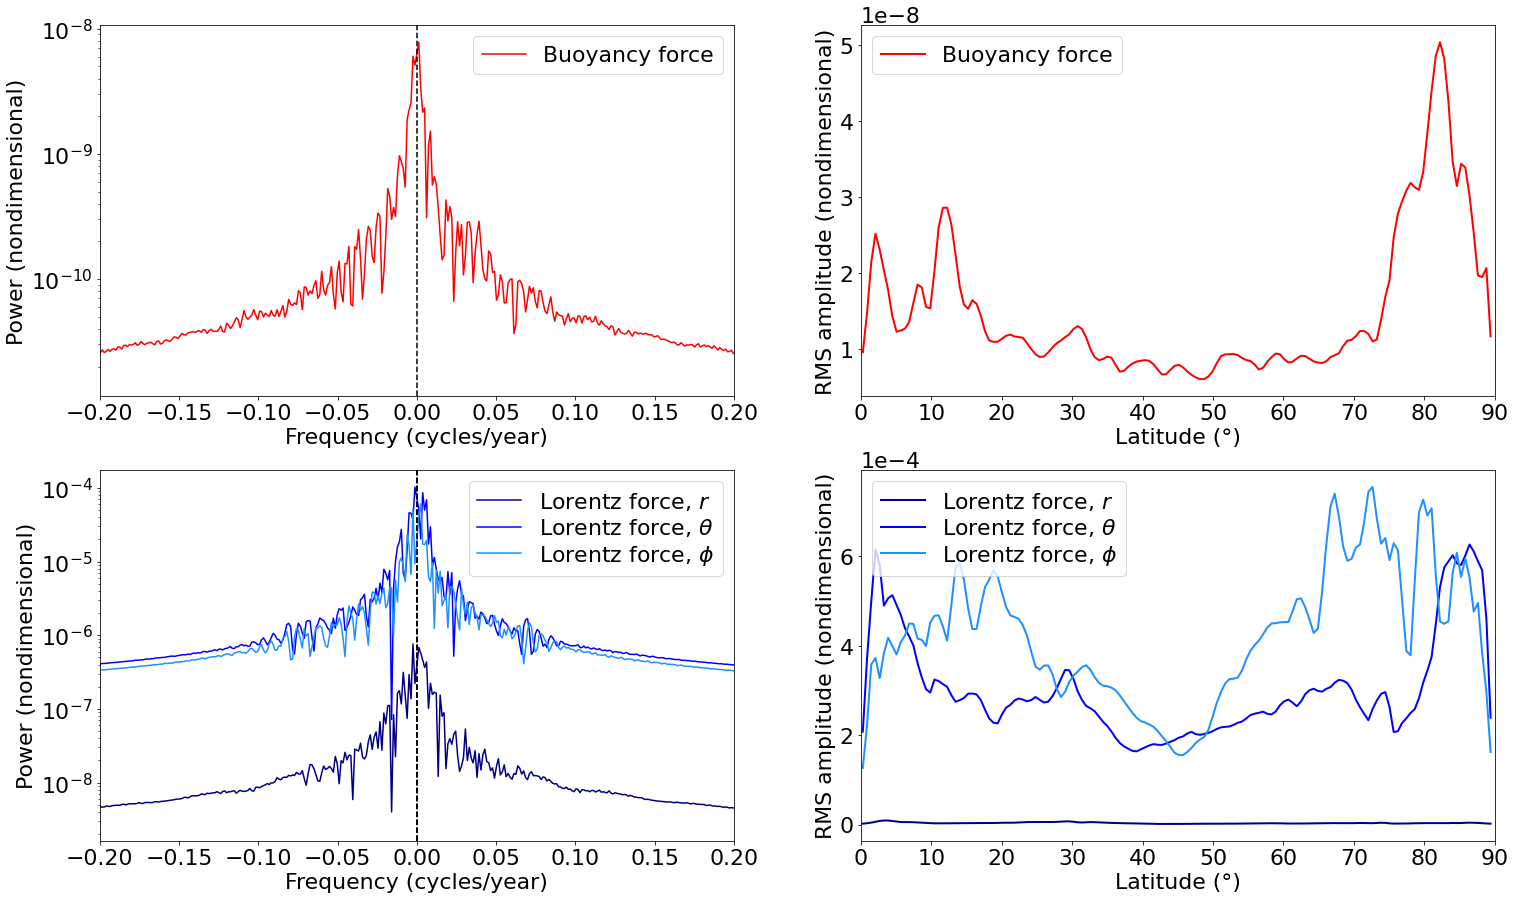

In [85]:
matplotlib.rcParams.update({'font.size':22})
fig = plt.figure(figsize=(25,15))
spec = gridspec.GridSpec(ncols=2, nrows=2, width_ratios= [3,3],figure=fig)
axb1  = fig.add_subplot(spec[0,0])
axb2  = fig.add_subplot(spec[0,1])
axl1  = fig.add_subplot(spec[1,0])
axl2  = fig.add_subplot(spec[1,1])

plot_spectrum_source(axb1,"buoyancy",temperature_y_layer_tilda_300,0.,0.,fixedparams,"Buoyancy force",'red')

plot_rms_source(axb2,"buoyancy",temperature_y_layer_tilda_300,0.,0.,fixedparams,"Buoyancy force",'red')

plot_spectrum_source(axl1,"lorentz",lorentz_r_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300   ,fixedparams,r"Lorentz force, $r$"     ,clr='navy')
plot_spectrum_source(axl1,"lorentz",0*lorentz_r_y_layer_tilda_300,lorentz_theta_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300,fixedparams,r"Lorentz force, $\theta$",clr='blue')
plot_spectrum_source(axl1,"lorentz",0*lorentz_r_y_layer_tilda_300,lorentz_phi_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300  ,fixedparams,r"Lorentz force, $\phi$"  ,clr='dodgerblue')

plot_rms_source(axl2,"lorentz",lorentz_r_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300   ,fixedparams,r"Lorentz force, $r$"     ,clr='navy')
plot_rms_source(axl2,"lorentz",0*lorentz_r_y_layer_tilda_300,lorentz_theta_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300,fixedparams,r"Lorentz force, $\theta$",clr='blue')
plot_rms_source(axl2,"lorentz",0*lorentz_r_y_layer_tilda_300,lorentz_phi_y_layer_tilda_300,0.*lorentz_r_y_layer_tilda_300  ,fixedparams,r"Lorentz force, $\phi$"  ,clr='dodgerblue')

axl1.legend(loc=1,labelspacing=0.2)
axl2.legend(loc=2,labelspacing=0.2)
axl2.ticklabel_format(scilimits=(-2,2))
fig.savefig('/Users/quentin.nicolas/Downloads/sources.eps', format='eps',bbox_inches='tight')

# Modes with GEV

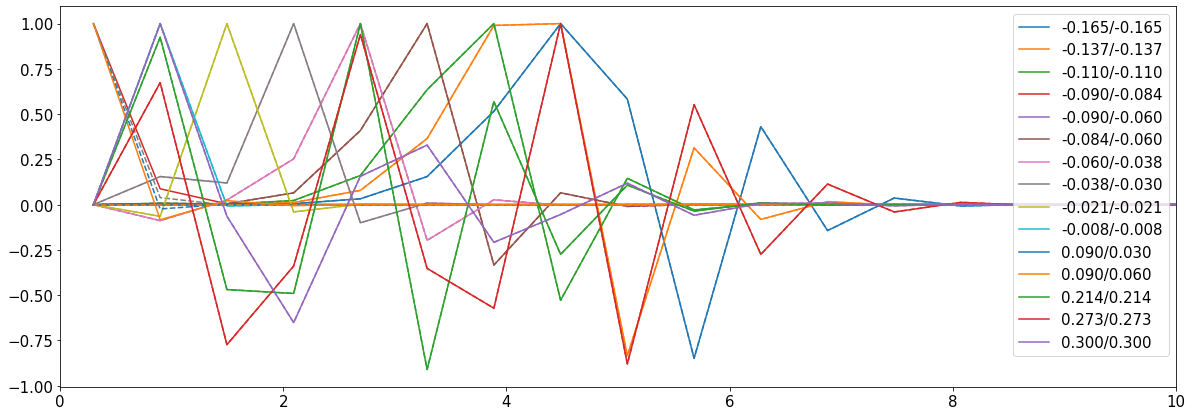

In [126]:
# Plotting the eigenmodes
def plot_eigenmodes_gev(n1,n2):
    ngrid=150
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    kprime = np.pi/Hprime
    omegaprime = 2*np.pi / ((-20)*sectoyear) / Omega
    
    C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Compute matrix and eigendecomposition; we make the approximation that eigenmodes don't change much if chi is changed
    Ag,Bg = set_AB(ngrid,m,M)
    wi_gev,xi_gev=spl.eig(Ag,Bg,left=False)
    
    A = set_A(ngrid,m,M)
    wi,xi=spl.eig(A,left=False)  
    
    #Sort eigenvectors by increasing period
    y=set_y(ngrid)
    xi=xi[:150,np.argsort(np.real(1/wi))]/(1-y[:,None]**2)
    xi=xi/np.diagonal(xi[np.abs(xi).argmax(axis=0)])
    wi=wi[np.argsort(np.real(1/wi))]
    xi_gev=xi_gev[:150,np.argsort(np.real(1/wi_gev))]/(1-y[:,None]**2)
    xi_gev=xi_gev/np.diagonal(xi_gev[np.abs(xi_gev).argmax(axis=0)])
    wi_gev=wi_gev[np.argsort(np.real(1/wi_gev))]

    _,ax=plt.subplots(1,1,figsize=(20,7))
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.plot(np.abs(wi)[140:155],np.abs(np.abs(wi_gev)/np.abs(wi)-1)[140:155],'-x')
    #ax.plot(np.abs(wi),np.abs(wi_gev),'-x')
    #lims = [
    #np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    #np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    #]
    #ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    #ax.set_aspect('equal')
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    for i in range(n1,n2):
        C0 = 2/0.65**2*kprime**2/Nprime**2
        eigenmode_period = np.real(2*np.pi*C0/(wi[i]*sectoyear*Omega))
        eigenmode_period_gev = np.real(2*np.pi*C0/(wi_gev[i]*sectoyear*Omega))
        ax.plot(np.arcsin(y)*180.0/np.pi,np.real(xi[:,i]),label="%.3f/%.3f"%(eigenmode_period,eigenmode_period_gev),color=colors[i%10])
        ax.plot(np.arcsin(y)*180.0/np.pi,np.real(xi_gev[:,i]),linestyle='--',color=colors[i%10])
    ax.legend(loc=1)
    ax.set_xlim(0,10)
plot_eigenmodes_gev(140,155)



# Forced waves with GEV

In [146]:


def solve_forced_problem_gev(y,A,B,C,rhs):
    ngrid=len(y)
    #print(np.linalg.cond(A-C*B),np.linalg.cond(A),np.linalg.cond(B))
    A = sps.csc_matrix(A)
    B = sps.csc_matrix(B)
    return spsl.spsolve(A-C*B,rhs)[:ngrid]/(1-y**2)

#  def solve_forced_problem_Nmodes_gev(y,A,B,C,rhs,nmodes):
#      ngrid=len(y)
#      n0=20
#      wi,zi,xi=spl.eig(A,B,left=True)
#      #Normalize left eigenvectors so that zj^H * xi = delta_ij
#      zi = zi/np.diagonal(np.dot(zi.transpose().conj(),np.dot(B,xi)))[None,:].conj()
#      #Sort eigenvectors by increasing period (on)
#      order=np.argpartition(np.real(1/wi),n0+nmodes)
#      xi=xi[:,order]
#      zi=zi[:,order]
#      wi=wi[order]
#      return np.sum(np.dot(zi[:,n0:n0+nmodes].conj().T,rhs)/(wi[n0:n0+nmodes]-C) * xi[:,n0:n0+nmodes],axis=1)[:ngrid]/(1-y**2)

In [177]:
def set_solve_forced_problem_gev(forcing_name,forcingtilda_r,forcingtilda_theta,forcingtilda_phi,m,freqindex,j,fixedparams,npoints=7,limitmodes=False,OPT=1):
    """Given a fourier transformed forcing, problem parameters, and a given frequency index and radial wavenumber, compute the forced wave response.
        - forcing_name       : str, either "buoyancy", "lorentz"
        - forcingtilda_r     : numpy.ndarray, temperature OR r-component of the Lorentz force, transformed in time and radius. Unused if forcingname=="induction". Dimensions are frequency, radial wavenumber, and y (=cos(latitude))
        - forcingtilda_theta : numpy.ndarray, unused if forcing_name is "buoyancy" OR theta-component of the Lorentz force OR theta-component of the magnetic field, transformed in time and radius. Dimensions are frequency, radial wavenumber, and y (=cos(latitude))
        - forcingtilda_phi   : numpy.ndarray, unused if forcing_name is "buoyancy" OR phi-component of the Lorentz force  OR phi-component of the magnetic field, transformed in time and radius. Dimensions are frequency, radial wavenumber, and y (=cos(latitude))
        - m                  : int, spherical harmonic order 
        - freqindex          : int, index of the frequency to pick.
        - j                  : int, radial wavenumber
        - fixedparams        : float iterable, contains in order E,Pm,Rastar,Hprime,Nprime,Brprime
        - npoints            : number of points for the finite difference stencil (forcing terms are differentiated to compute the rhs)
    returns :
        - numpy.ndarray of length ngrid, solution of the forced wave problem (magnetic perturbation \tilde b_theta)
    """
    # Compute C and M
    ngrid = forcingtilda_r.shape[2]  
    period = freqindex_to_period(freqindex)
    
    E,Pm,_,Hprime,Nprime,Brprime=fixedparams
    sectoyear = 365.25 * 24 * 60 * 60
    Omega = 2*np.pi/86400
    
    kprime = np.pi*j/Hprime
    omegaprime = 2*np.pi / (period*sectoyear) / Omega
    
    C = 2/0.65**2*kprime**2/Nprime**2*omegaprime
    chi = 1 +1j*kprime**2/omegaprime*E/Pm
    M = 1/(0.65**2)*Brprime**2*kprime**4/(chi*Nprime**2)
    
    # Set up unforced problem
    y = set_y(ngrid)
    A,B = set_AB(ngrid,m,M,npoints)
    
    # Compute forcings & setup RHS
    if forcing_name == "induction":
        FItheta_pp = forcingtilda_theta[freqindex,j-1,:]*(1-y**2)
        FIphi_p = forcingtilda_phi[freqindex,j-1,:]/np.sqrt(1-y**2)
        rhs = set_rhs_induction_forcing_gev(y,C,m,M,chi,FItheta_pp,FIphi_p,npoints,OPT)
    else:
        if forcing_name == "buoyancy":
            Fr,Ftheta,Fphi = set_buoyancy_forcing(forcingtilda_r,freqindex,j,fixedparams)
        elif forcing_name == "lorentz":
            Fr,Ftheta,Fphi = set_lorentz_forcing(forcingtilda_r,forcingtilda_theta,forcingtilda_phi,freqindex,j,fixedparams)
        rhs = set_rhs_forcing_gev(y,C,m,M,Fr,Ftheta,Fphi,npoints)
    
    # Solve forced problem
    if limitmodes:
        return solve_forced_problem_Nmodes_gev(y,A,B,C,rhs,limitmodes)
    else:
        return solve_forced_problem_gev(y,A,B,C,rhs)




In [176]:
def set_AB(ngrid,m,M,npoints=7):
    """ Sets the matrix A of the wave eigenvalue problem (A - C*In)x = 0
    args :
        - ngrid   : int, number of points in y
        - m       : int, spherical harmonic order 
        - M       : float, nondimensional number scaling Magnetic force vs buoyancy force in the MAC balance
        - npoints : number of points for the finite difference stencil (A contains a second order derivative)
    returns :
        - numpy.ndarray of the same shape as x except along the axis, where its length is incremented by 1
    """
    y  = set_y(ngrid)
    D2 = make_D_fornberg(y,2,npoints=npoints) #Matrix of second differentiation
    
    L1 = -np.dot(np.diag(M*(1-y**2)), D2) + np.diag(M*(m**2-1)/(1-y**2))
    L2 = -m*np.eye(ngrid)
    
    A = np.block([[np.zeros((ngrid,ngrid)),np.eye(ngrid)],[L1,L2]])
    B = np.block([[np.eye(ngrid),np.zeros((ngrid,ngrid))],[np.zeros((ngrid,ngrid)),np.diag(y**2)]])
    
    #Enforce Dirichlet boundary conditions
    A[len(y)] = np.zeros(len(A))
    A[-1] = np.zeros(len(A))
    scale=np.abs(A[len(y)+1,0])
    A[len(y),0]=   1
    A[-1,len(y)-1]=1
    # The following avoids numerical errors at the boundaries, that appear when the boundary condition is specified too weakly
    A[len(y)] *= scale**2
    A[-1]    *= scale**2
    
    
    return A,B

def set_rhs_forcing_gev(y,C,m,M,Fr,Ftheta,Fphi,npoints=7):
    ngrid=len(y)
    
    D1 = make_D_fornberg(y,1,npoints=npoints)
    
    forcingr     = -(C*m/M + 2)*y*Fr/(1-y**2)**(0.5)
    forcingtheta = m**2/(M*(1-y**2)) * Ftheta
    forcingphi   = -1j* ( (C/M + 2/m)*y*Fphi
                          + m/(M*(1-y**2)**(0.5)) * np.dot(D1,Fphi*(1-y**2)**(0.5)) 
                         )
    rhs = np.concatenate([np.zeros(ngrid),-(forcingr+forcingtheta+forcingphi)*M*(1-y**2)])  
    return rhs

def set_rhs_induction_forcing_gev(y,C,m,M,chi,FItheta_pp,FIphi_p,npoints=7,OPT=1):
    """Computes the right hand side of the forced wave problem arising from large-scale induction as a source mechanism.
    The RHS is a vector of length 2*ngrid whose first n components are zero, and next n are functions of the nondimensional forcings FItheta and FIphi
    args :
        - y       : numpy.array, grid (length=ngrid)
        - C       : float, nondimensional number scaling Coriolis force vs buoyancy force in the MAC balance. Also acts as the eigenvalue parameter in this eigenvalue problem (it is proportional to the wave frequency) 
        - m       : int, spherical harmonic order 
        - M       : float, nondimensional number scaling Magnetic force vs buoyancy force in the MAC balance
        - FItheta_pp  : numpy.array, theta component of the time integral of the nondimensional induction forcing term (length=ngrid, this is typically the theta-component of the large-scale magnetic field times 1-y^2)
        - FIphi_p    : numpy.array, phi component of the time integral of the nondimensional induction forcing term (length=ngrid, this is typically the phi-component of the large-scale magnetic field divided by sqrt(1-y^2))
        - npoints : number of points for the finite difference stencil (forcing terms are differentiated to compute the rhs)
    returns :
        - numpy.ndarray of length ngrid, right hand side of the discretized wave equation
    """
    ngrid=len(y)
    
    D1 = make_D_fornberg(y,1,npoints=npoints)
    D2 = make_D_fornberg(y,2,npoints=npoints)
    
    if OPT==1:
        forcingtheta = 1/chi*(np.dot(D2,FItheta_pp) + (C**2*y**2+m*C)/(M*(1-y**2))*FItheta_pp + (1-y**2)**(-2)*FItheta_pp)
    elif OPT==2:
        forcingtheta = 1/chi*((C**2*y**2+m*C)/(M*(1-y**2))*FItheta_pp + (1-y**2)**(-2)*FItheta_pp)
    forcingphi =   1/chi*(-1j*m*(1-y**2)**(0.5)*np.dot(D1,FIphi_p) - 1j*C*y*(1-y**2)**(0.5)*FIphi_p + 2j*m*y*(1-y**2)**(-0.5)*FIphi_p)
    rhs = np.concatenate([np.zeros(ngrid),-(forcingtheta+forcingphi)*M*(1-y**2)])  
    return rhs

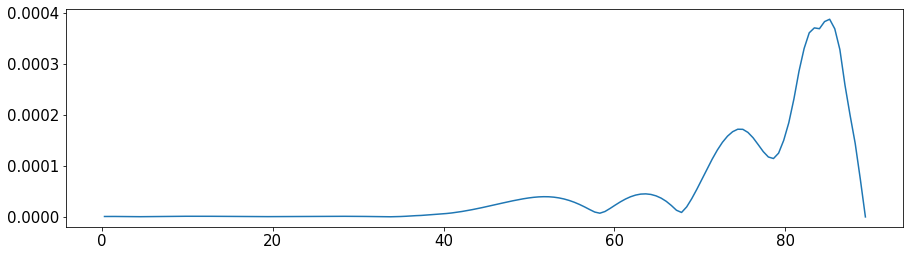

In [135]:
freqindex=period_to_freqindex(-17)
fig,ax=plt.subplots(1,1,figsize=(15,4))
test=set_solve_forced_problem("lorentz",zero,lorentz_theta_y_layer_tilda_150_NH,zero,m,freqindex,1,fixedparams)
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(test))

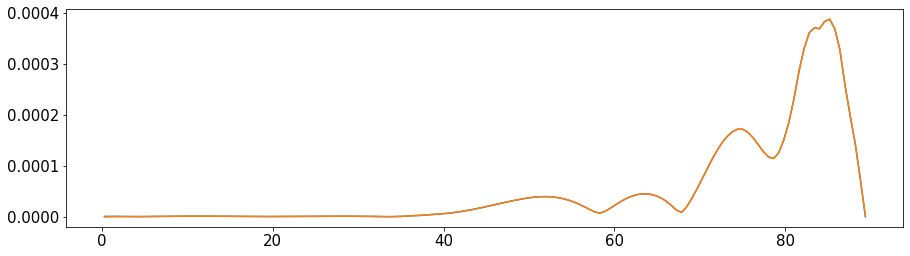

In [156]:
freqindex=period_to_freqindex(-17)
fig,ax=plt.subplots(1,1,figsize=(15,4))
test_gev=set_solve_forced_problem_gev("lorentz",zero,lorentz_theta_y_layer_tilda_150_NH,zero,m,freqindex,1,fixedparams)
test=set_solve_forced_problem("lorentz",zero,lorentz_theta_y_layer_tilda_150_NH,zero,m,freqindex,1,fixedparams)

ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(test))
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(test_gev))

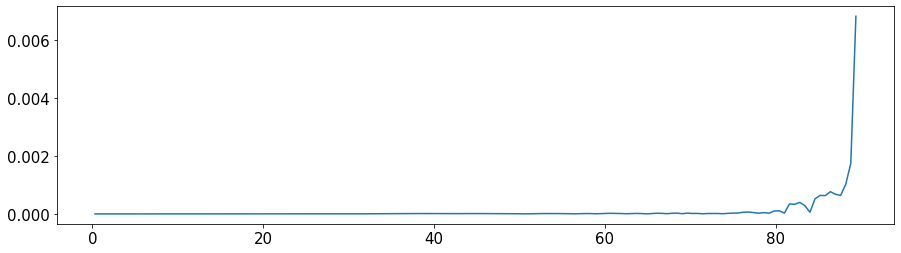

In [151]:
freqindex=period_to_freqindex(-17)
fig,ax=plt.subplots(1,1,figsize=(15,4))
test=set_solve_forced_problem_gev("lorentz",zero,lorentz_theta_y_layer_tilda_150_NH,zero,m,freqindex,1,fixedparams)
ax.plot(np.arcsin(y)*180.0/np.pi,np.abs(test))